# A Crop/Weed Field Image Dataset
https://github.com/cwfid/dataset

@inproceedings{haug15,
  author={Haug, Sebastian and Ostermann, J{\"o}rn},
  title={A Crop/Weed Field Image Dataset for the Evaluation of Computer Vision Based Precision Agriculture Tasks},
  year={2015},
  booktitle={Computer Vision - ECCV 2014 Workshops},
  doi={10.1007/978-3-319-16220-1_8},
  url={ http://dx.doi.org/10.1007/978-3-319-16220-1_8 },
  pages={105--116},
}


In [2]:


from __future__ import absolute_import, division, print_function
#from model_all import SqueezeNetModel, SqueezeNet11Model, SqueezeNetSEAutoModel
from keras_tuner import RandomSearch, BayesianOptimization, Hyperband

from random import randint, choices, shuffle
from random import seed
from keras_tuner.engine import hypermodel
from keras_tuner import HyperParameters, Objective

from keras_tuner import HyperParameters
import tensorflow.keras.backend as K
import cv2
from tensorflow import keras

import os


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'




In [3]:
import os
import numpy as np

from skimage.io import imread
from skimage.transform import resize,rotate
from skimage.measure import find_contours
from skimage.util import invert
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
plt.style.use('default')

import keras.backend as K
import keras
from keras import layers, activations
from keras.models import Model
from keras.preprocessing.image import load_img,img_to_array
from keras.utils.vis_utils import plot_model
#from keras.engine.topology import Layer
from tensorflow.keras.layers import Layer

from IPython.display import Image
import tensorflow as tf

import yaml

## Dataset download

In [3]:
!wget https://github.com/cwfid/dataset/archive/v1.0.tar.gz 
!tar -zxf v1.0.tar.gz

--2023-05-15 17:10:50--  https://github.com/cwfid/dataset/archive/v1.0.tar.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/cwfid/dataset/tar.gz/refs/tags/v1.0 [following]
--2023-05-15 17:10:50--  https://codeload.github.com/cwfid/dataset/tar.gz/refs/tags/v1.0
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v1.0.tar.gz’

v1.0.tar.gz             [   <=>              ]  86.12M  5.25MB/s    in 15s     

2023-05-15 17:11:06 (5.84 MB/s) - ‘v1.0.tar.gz’ saved [90303402]



In [4]:
!ls dataset-1.0

annotations  images  masks  README.md  train_test_split.yaml


In [91]:
for root, dirs, files in os.walk("dataset-1.0"):
    print(root)
    print(sorted(files))

dataset-1.0
['README.md', 'train_test_split.yaml']
dataset-1.0/annotations
['001_annotation.png', '001_annotation.yaml', '002_annotation.png', '002_annotation.yaml', '003_annotation.png', '003_annotation.yaml', '004_annotation.png', '004_annotation.yaml', '005_annotation.png', '005_annotation.yaml', '006_annotation.png', '006_annotation.yaml', '007_annotation.png', '007_annotation.yaml', '008_annotation.png', '008_annotation.yaml', '009_annotation.png', '009_annotation.yaml', '010_annotation.png', '010_annotation.yaml', '011_annotation.png', '011_annotation.yaml', '012_annotation.png', '012_annotation.yaml', '013_annotation.png', '013_annotation.yaml', '014_annotation.png', '014_annotation.yaml', '015_annotation.png', '015_annotation.yaml', '016_annotation.png', '016_annotation.yaml', '017_annotation.png', '017_annotation.yaml', '018_annotation.png', '018_annotation.yaml', '019_annotation.png', '019_annotation.yaml', '020_annotation.png', '020_annotation.yaml', '021_annotation.png', '0

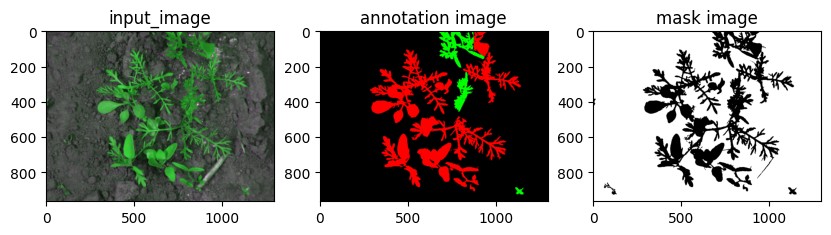

(966, 1296)


In [3]:
# red = weed, green = crop

pardir = "dataset-1.0"
img = imread(os.path.join(pardir,"images","001_image.png"))

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input_image")
plt.imshow(img)

plt.subplot(1,3,2)
img = imread(os.path.join(pardir,"annotations","001_annotation.png"))
plt.title("annotation image")
plt.imshow(img)

plt.subplot(1,3,3)
img = imread(os.path.join(pardir,"masks","001_mask.png"))
plt.title("mask image")
plt.imshow(img,cmap="gray")
plt.show()
print(img.shape)

(128, 128)


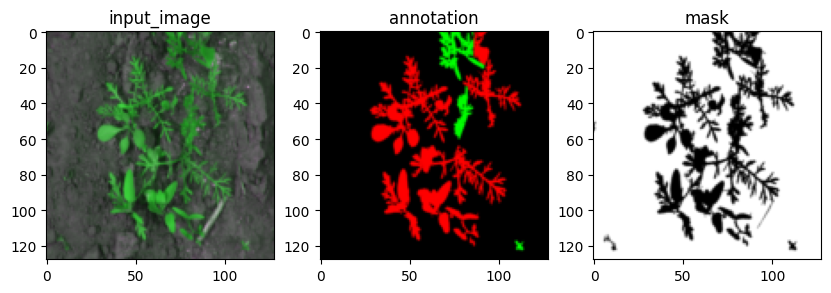

In [4]:
#for training speed, will resize it to 128, 128

pardir = "dataset-1.0"
img = imread(os.path.join(pardir,"images","001_image.png"))
img = resize(img,(128,128))

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input_image")
plt.imshow(img)

img = imread(os.path.join(pardir,"annotations","001_annotation.png"))
img = resize(img,(128,128))

plt.subplot(1,3,2)
plt.title("annotation")
plt.imshow(img)

img = imread(os.path.join(pardir,"masks","001_mask.png"))
img = resize(img,(128,128))

plt.subplot(1,3,3)
plt.title("mask")
plt.imshow(img,cmap="gray")

print(img.shape)

## Region Segmentation (plant region isolation)

### u-net model preparation
image from https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

![image](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [3]:
def small_Unet(labels=1,h=128,w=128, out_activation = "sigmoid"):
    
    class MySoftmax(Layer):
        #http://cookie-box.hatenablog.com/entry/2017/08/15/231503 
        def __init__(self, **kwargs):
            super(MySoftmax, self).__init__(**kwargs)
        def call(self, x):
            return(activations.softmax(x, axis=3))

    
    
    #block1, 128x128
    inputs = layers.Input(shape=(h,w,3))
    conv11 = layers.Conv2D(16,(3,3),activation="relu",padding="same")(inputs)
    conv12= layers.Conv2D(16,(3,3),activation="relu",padding="same")(conv11)
    conv13= layers.Conv2D(16,(3,3),activation="relu",padding="same")(conv12)
    pool1 = layers.MaxPool2D((2,2))(conv13)
    drop1 = layers.Dropout(0.5)(pool1)
   #block2 64x64
    conv21 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(drop1)
    conv22 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(conv21)
    conv23 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(conv22)
    pool2 = layers.MaxPool2D((2,2))(conv23)
    drop2 = layers.Dropout(0.5)(pool2)
    #block3 32x32
    conv31 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(drop2)
    conv32 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv31)
    conv33 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv32)
    pool3 = layers.MaxPool2D((2,2))(conv33)
    drop3 = layers.Dropout(0.5)(pool3)

    #block4 16x16
    conv41 = layers.Conv2D(128,(3,3),activation="relu",padding="same")(drop3)
    conv42 = layers.Conv2D(128,(3,3),activation="relu",padding="same")(conv41)
    conv43 = layers.Conv2D(128,(3,3),activation="relu",padding="same")(conv42)
    pool4 = layers.MaxPool2D((2,2))(conv43)
    drop4 = layers.Dropout(0.5)(pool4)
    
    #bottom of Unet 8x8
    conv5 = layers.Conv2D(256,(3,3),activation="relu",padding="same")(drop4)
    conv5 = layers.Conv2D(256,(3,3),activation="relu",padding="same")(conv5)

    #upblock4
    x = layers.UpSampling2D((2,2))(conv5)
    x = layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv43,x])
    x= layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #upblock3
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv33,x])
    x= layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #upblock2
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv23,x])
    x= layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #upblock1
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv13,x])
    x= layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #to label image (2 labels)
    x = layers.Conv2D(labels,(1,1))(x)
    if out_activation == "sigmoid":
        outputs = layers.Activation("sigmoid")(x)
    elif out_activation == "softmax":
        outputs =MySoftmax()(x)
    elif  out_activation == None:
        outputs = x
    model = Model(inputs=inputs,outputs=outputs)
    return model

In [6]:
K.clear_session()


model = small_Unet(labels=1)  


#https://stackoverflow.com/questions/49785133/keras-dice-coefficient-loss-function-is-negative-and-increasing-with-epochs
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2.0 * intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


model.compile(loss=dice_coef_loss,optimizer="rmsprop",metrics=['accuracy'])

2023-05-18 14:07:50.263604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 14:07:50.264210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 14:07:50.337072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 14:07:50.337371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 14:07:50.337681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

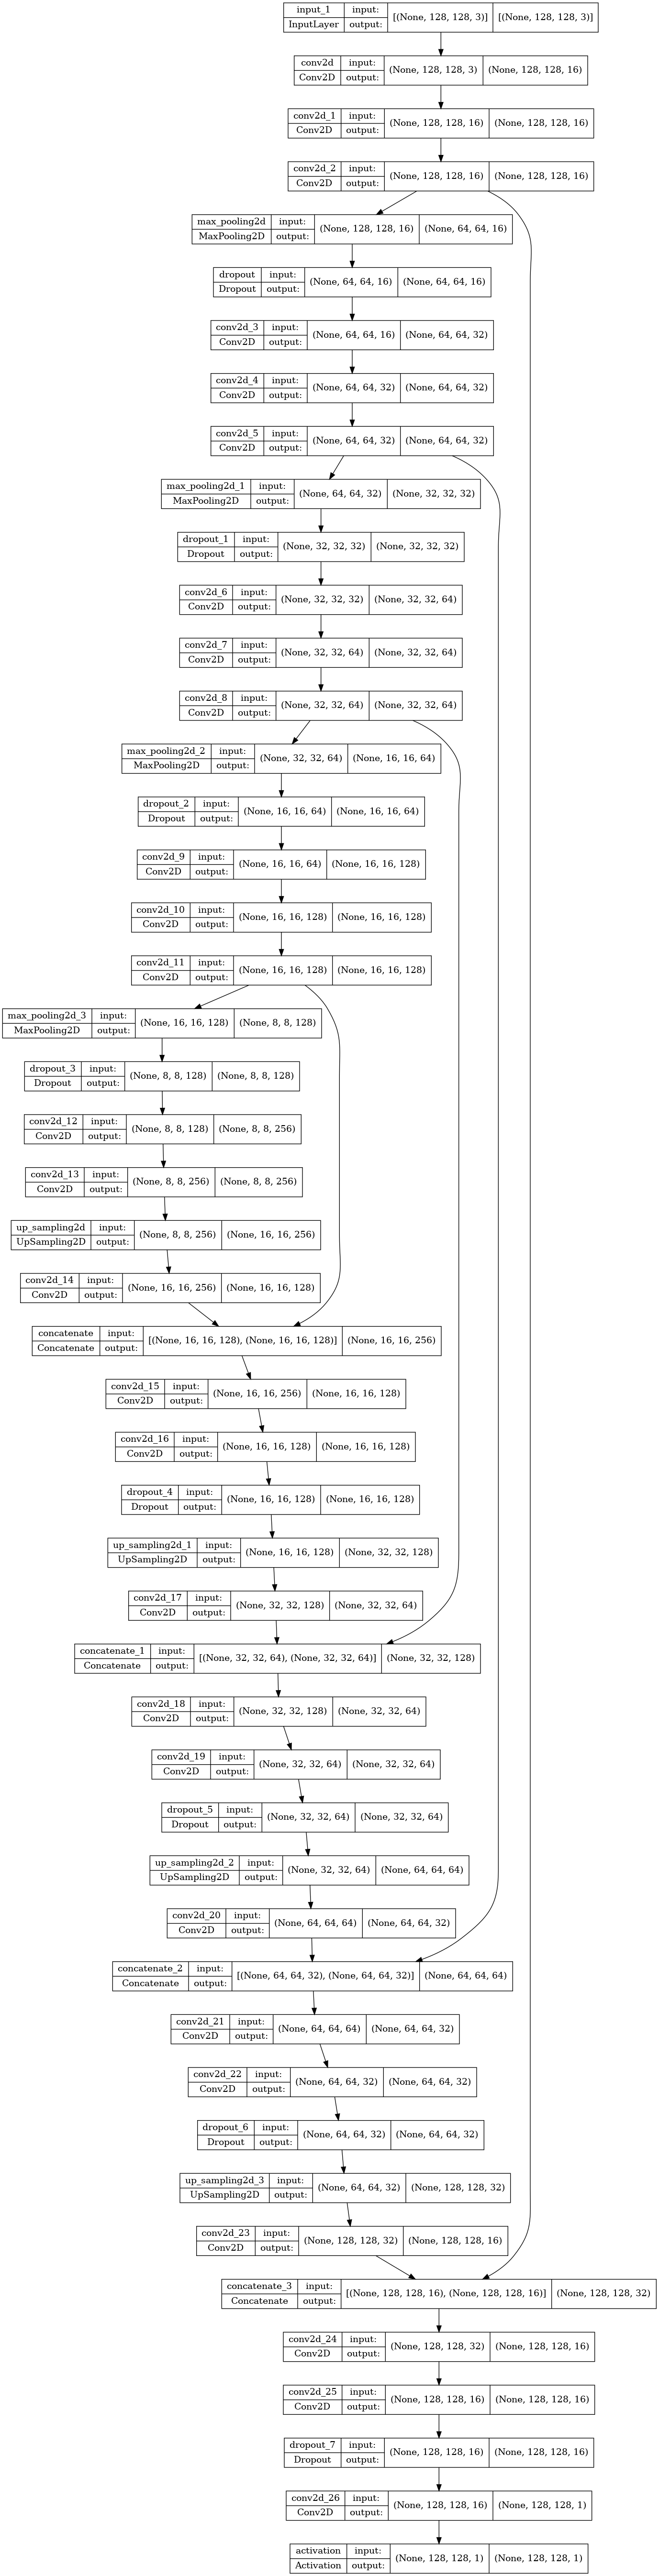

In [8]:
#alternative visualization of model structure
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

Image("model_plot.png")

### data preparation

In [92]:
for root, dirs, files in os.walk("dataset-1.0"):
    print(root)
    print(sorted(files))

print("\n")
    
with open("dataset-1.0/train_test_split.yaml","r") as f:
    data = yaml.full_load(f)

print(data)
print("train_data is:",data["train"])
print("test_data is:",data["test"])


dataset-1.0
['README.md', 'train_test_split.yaml']
dataset-1.0/annotations
['001_annotation.png', '001_annotation.yaml', '002_annotation.png', '002_annotation.yaml', '003_annotation.png', '003_annotation.yaml', '004_annotation.png', '004_annotation.yaml', '005_annotation.png', '005_annotation.yaml', '006_annotation.png', '006_annotation.yaml', '007_annotation.png', '007_annotation.yaml', '008_annotation.png', '008_annotation.yaml', '009_annotation.png', '009_annotation.yaml', '010_annotation.png', '010_annotation.yaml', '011_annotation.png', '011_annotation.yaml', '012_annotation.png', '012_annotation.yaml', '013_annotation.png', '013_annotation.yaml', '014_annotation.png', '014_annotation.yaml', '015_annotation.png', '015_annotation.yaml', '016_annotation.png', '016_annotation.yaml', '017_annotation.png', '017_annotation.yaml', '018_annotation.png', '018_annotation.yaml', '019_annotation.png', '019_annotation.yaml', '020_annotation.png', '020_annotation.yaml', '021_annotation.png', '0

In [93]:
#read image into memory
####

train_x = []
train_y = []
test_x = []
test_y = []


for number in data["train"]:
    
    number = "{0:03d}".format(number)
    
    x_path = os.path.join("dataset-1.0","images",str.format(number)) + "_image.png" 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    train_x.append(img)
    
    y_path = os.path.join("dataset-1.0","masks",str(number)) + "_mask.png" 
    img = load_img(y_path,target_size=(128,128),color_mode="grayscale")
    img = img_to_array(img,dtype="uint8")

    img = invert(img)/255.
    train_y.append(img)
    
    
for number in data["test"]:

    number = "{0:03d}".format(number)

    x_path = os.path.join("dataset-1.0","images",str.format(number)) + "_image.png" 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    test_x.append(img)
    
    y_path = os.path.join("dataset-1.0","masks",str(number)) + "_mask.png" 
    img = load_img(y_path,target_size=(128,128),color_mode="grayscale")
    img = img_to_array(img,dtype="uint8")
    
    img = invert(img)/255.
    test_y.append(img)

    
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)


#check shape
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(40, 128, 128, 3)
(40, 128, 128, 1)
(21, 128, 128, 3)
(21, 128, 128, 1)


### training

In [11]:
#note, due to no augmentation and the number of datasize, the loss does not converge sometime.
#in such case, reinitialize and retrain the model.
history = model.fit(train_x, train_y, batch_size=10, epochs=2,verbose=1,validation_data=(test_x,test_y))

Epoch 1/2


2023-05-18 14:08:17.280698: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-05-18 14:08:18.567100: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


4/4 [==============================] - 5s 101ms/step - loss: 0.8533 - accuracy: 0.2014 - val_loss: 0.8538 - val_accuracy: 0.0789
Epoch 2/2
4/4 [==============================] - 0s 30ms/step - loss: 0.8486 - accuracy: 0.0912 - val_loss: 0.8537 - val_accuracy: 0.0789


### use the model

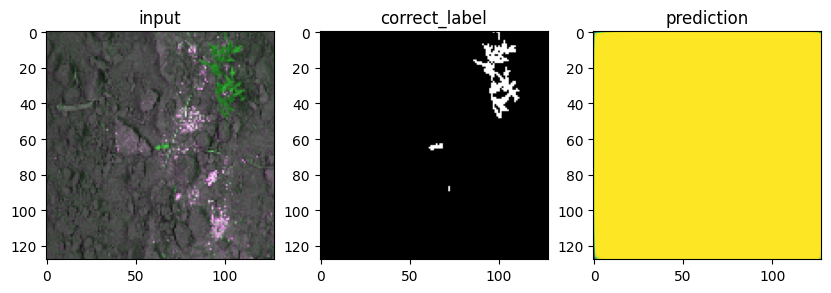

In [12]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n =7

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(1,3,2)
plt.title("correct_label")
plt.imshow(test_y[n,:,:,0],cmap="gray")


prediction = model.predict(test_x[n:n+1])
#prediction shape will be (1,128,128,1)

plt.subplot(1,3,3)
plt.title("prediction")
plt.imshow(prediction[0,:,:,0])

## Region Segmentation (crop weed segmentation)

In [13]:
#do not use for now

#modified based on https://github.com/keras-team/keras/issues/9395

#---------------------------------------------------------------------------------------------------------------------#
#generalized dice loss
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=2):
    dice=0
    for index in range(numLabels):
        #dice -= dice_coef(y_true[:,index,:,:,:], y_pred[:,index,:,:,:])
        dice -= dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
    return dice
#---------------------------------------------------------------------------------------------------------------------#
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
   #num = K.sum(p0*g0, (0,1,2,3))
    num = K.sum(p0*g0, (0,1,2))
    #den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T
#---------------------------------------------------------------------------------------------------------------------#


### u-net model preparation

In [14]:
K.clear_session()

unet = small_Unet(labels=3,out_activation=None)  
l = layers.Reshape((128*128,3))(unet.output)
outs = layers.Activation("softmax")(l)

model = Model(inputs=unet.input,outputs=outs)

#model.compile(loss=dice_coef_multilabel,optimizer="rmsprop")
#model.compile(loss=tversky_loss,optimizer="rmsprop")
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=['accuracy'])

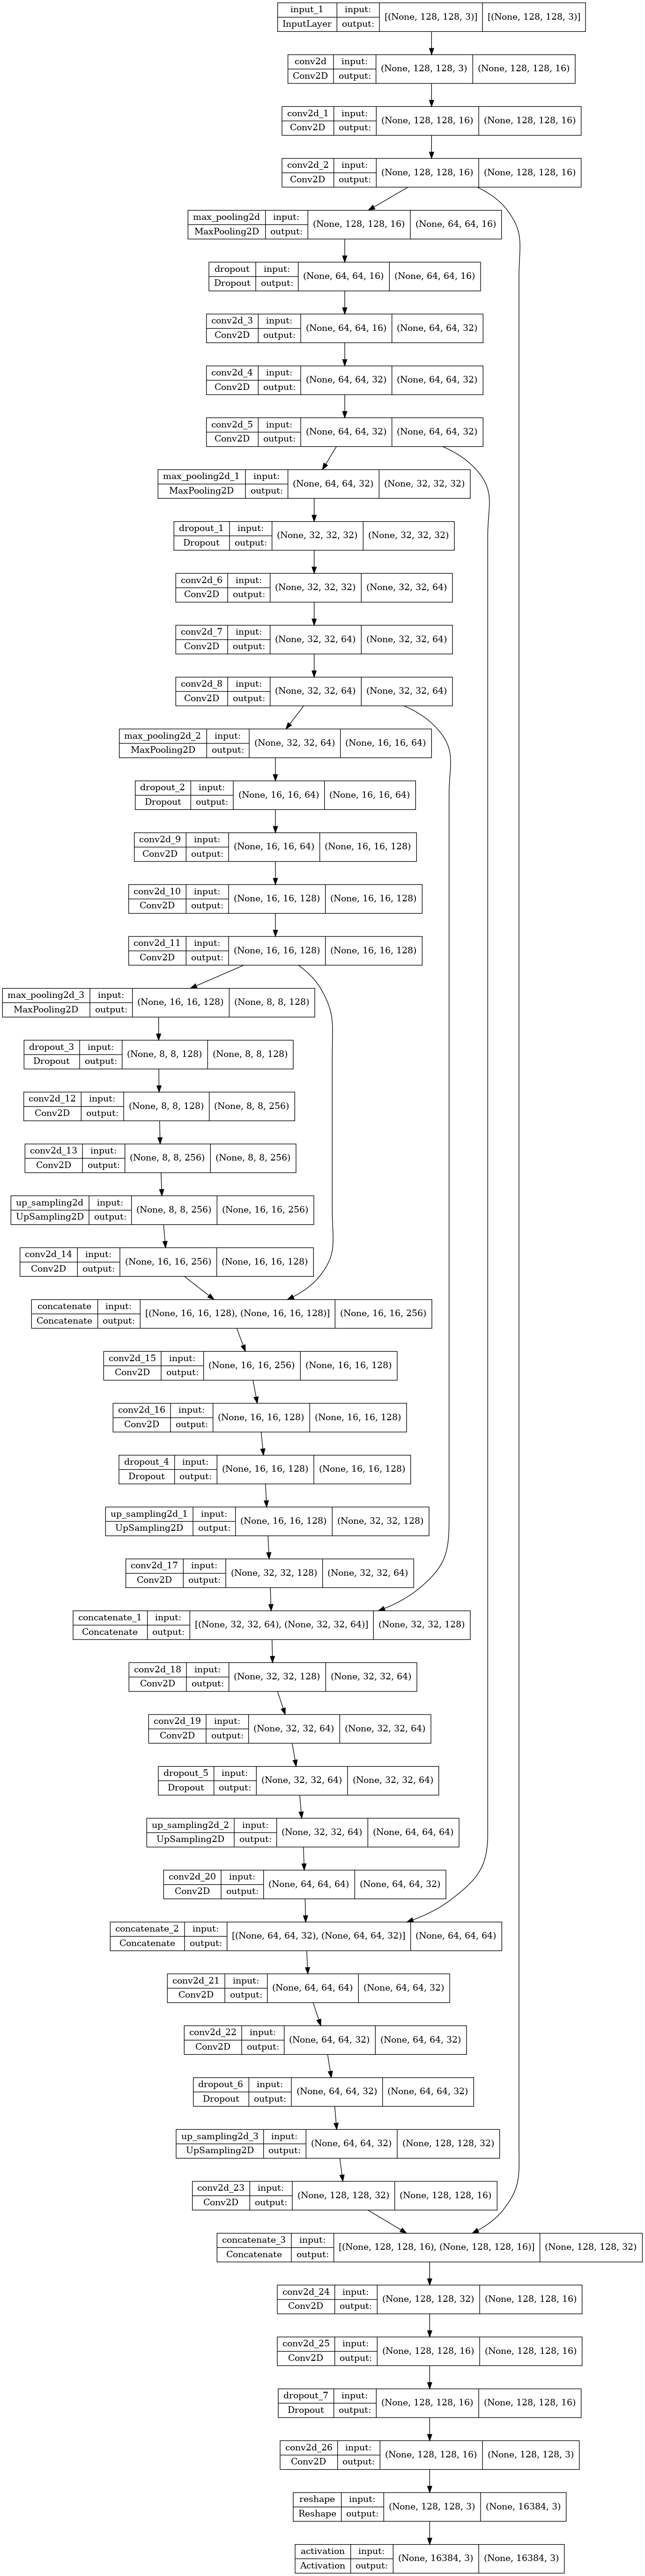

In [15]:
#alternative visualization of model structure
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

Image("model_plot.png")

### data preparation

In [3]:
#read image into memory
for root, dirs, files in os.walk("dataset-1.0"):
    print(root)
    print(sorted(files))

print("\n")
    
with open("dataset-1.0/train_test_split.yaml","r") as f:
    data = yaml.full_load(f)

print(data)
print("train_data is:",data["train"])
print("test_data is:",data["test"])

train_x = []
train_y = []
test_x = []
test_y = []


for number in data["train"]:

    number = "{0:03d}".format(number)

    x_path = os.path.join("dataset-1.0","images",str.format(number)) + "_image.png" 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    train_x.append(img)
    

    y_path = os.path.join("dataset-1.0","annotations",str(number)) + "_annotation.png" 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    y[:,:, 0] = weed
    y[:, :, 1] = crop
    
    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    
    train_y.append(y)
    
    
for number in data["test"]:
    number = "{0:03d}".format(number)

    x_path = os.path.join("dataset-1.0","images",str.format(number)) + "_image.png" 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    test_x.append(img)
    
    y_path = os.path.join("dataset-1.0","annotations",str(number)) + "_annotation.png" 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    
    y[:,:, 0] = weed
    y[:, :,1] = crop

    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    test_y.append(y)

    
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

#check shape
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


dataset-1.0
['README.md', 'train_test_split.yaml']
dataset-1.0/annotations
['001_annotation.png', '001_annotation.yaml', '002_annotation.png', '002_annotation.yaml', '003_annotation.png', '003_annotation.yaml', '004_annotation.png', '004_annotation.yaml', '005_annotation.png', '005_annotation.yaml', '006_annotation.png', '006_annotation.yaml', '007_annotation.png', '007_annotation.yaml', '008_annotation.png', '008_annotation.yaml', '009_annotation.png', '009_annotation.yaml', '010_annotation.png', '010_annotation.yaml', '011_annotation.png', '011_annotation.yaml', '012_annotation.png', '012_annotation.yaml', '013_annotation.png', '013_annotation.yaml', '014_annotation.png', '014_annotation.yaml', '015_annotation.png', '015_annotation.yaml', '016_annotation.png', '016_annotation.yaml', '017_annotation.png', '017_annotation.yaml', '018_annotation.png', '018_annotation.yaml', '019_annotation.png', '019_annotation.yaml', '020_annotation.png', '020_annotation.yaml', '021_annotation.png', '0

#### Inspect how the dataset was read

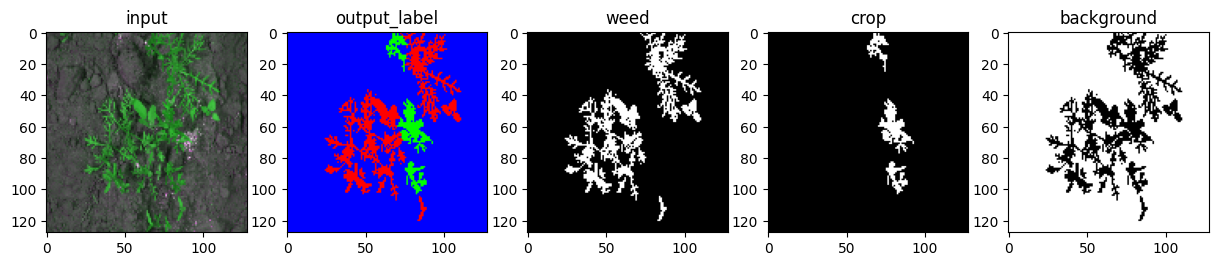

In [17]:
n = 3

plt.figure(figsize=(15,3))
plt.subplot(1,5,1)
plt.title("input")
plt.imshow(train_x[n])

plt.subplot(1,5,2)
plt.title("output_label")
img = np.reshape(train_y[n, :],(128,128,3))
plt.imshow(img,)

plt.subplot(1,5,3)
plt.title("weed")
img = np.reshape(train_y[n, :, 0],(128,128))
plt.imshow(img,cmap="gray")

plt.subplot(1,5,4)
plt.title("crop")
img = np.reshape(train_y[n, :, 1],(128,128))
plt.imshow(img,cmap="gray")

plt.subplot(1,5,5)
plt.title("background")
img = np.reshape(train_y[n, :, 2],(128,128))
plt.imshow(img,cmap="gray")

### training

In [108]:
history = model.fit(train_x, train_y, batch_size=10, epochs=150, verbose=1,validation_data=(test_x,test_y))

Epoch 1/150
4/4 [==============================] - 0s 56ms/step - loss: 1.2971 - accuracy: 0.9234 - val_loss: 1.2652 - val_accuracy: 0.9440
Epoch 2/150
4/4 [==============================] - 0s 35ms/step - loss: 1.2338 - accuracy: 0.9275 - val_loss: 1.5124 - val_accuracy: 0.9470
Epoch 3/150
4/4 [==============================] - 0s 33ms/step - loss: 1.5276 - accuracy: 0.9194 - val_loss: 1.2677 - val_accuracy: 0.9436
Epoch 4/150
4/4 [==============================] - 0s 32ms/step - loss: 1.3333 - accuracy: 0.9228 - val_loss: 1.3846 - val_accuracy: 0.9524
Epoch 5/150
4/4 [==============================] - 0s 32ms/step - loss: 1.2880 - accuracy: 0.9283 - val_loss: 1.4397 - val_accuracy: 0.9419
Epoch 6/150
4/4 [==============================] - 0s 32ms/step - loss: 1.3214 - accuracy: 0.9195 - val_loss: 1.4060 - val_accuracy: 0.9272
Epoch 7/150
4/4 [==============================] - 0s 32ms/step - loss: 1.4829 - accuracy: 0.9158 - val_loss: 1.2796 - val_accuracy: 0.9360
Epoch 8/150
4/4 [===

### evaluation

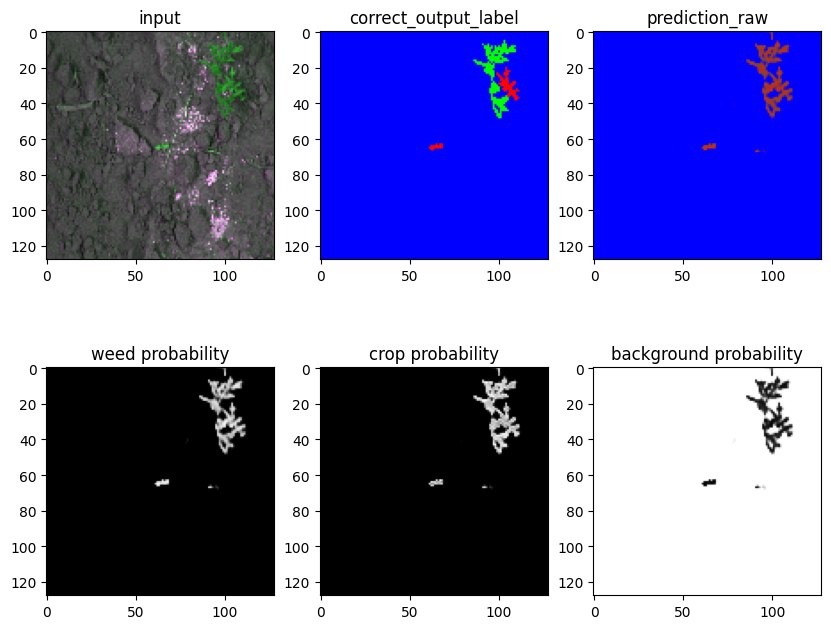

In [19]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 7

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")

## Resolving class imblance

38426.0
10319.0
606615


Text(0, 0.5, 'px')

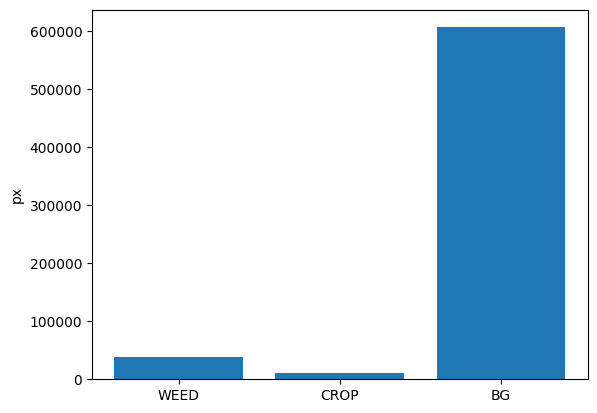

In [20]:
# calculate total pixel per label in train dataset

weed_pixel = 0
crop_pixel = 0
background_pixel = 0

for number in data["train"]:

    number = "{0:03d}".format(number)

    y_path = os.path.join("dataset-1.0","annotations",str(number)) + "_annotation.png" 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255

    weed = img[:,:,0]
    _pixel = np.sum(weed.flatten())
    weed_pixel += _pixel 
    crop = img[:,:,1]
    _pixel = np.sum(crop.flatten())
    crop_pixel += _pixel

    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1) * 1
    _pixel = np.sum(back.flatten())
    background_pixel += _pixel


print(weed_pixel)
print(crop_pixel)
print(background_pixel)

plt.bar(["WEED","CROP","BG"],[weed_pixel,crop_pixel,background_pixel])
plt.ylabel("px")

In [21]:
class_weight = [background_pixel/weed_pixel, background_pixel/crop_pixel, 1]
print(class_weight)


[15.786576796960391, 58.78621959492199, 1]


In [27]:
#categorical crossentropy with losses
#https://forums.fast.ai/t/unbalanced-classes-in-image-segmentation/18289/2
def weighted_categorical_crossentropy(weights):
    """ weighted_categorical_crossentropy

        Args:
            * weights<ktensor|nparray|list>: crossentropy weights
        Returns:
            * weighted categorical crossentropy function
    """
    if isinstance(weights,list) or isinstance(np.ndarray):
        weights=K.variable(weights)

    def loss(target,output,from_logits=False):
        if not from_logits:
            output /= tf.reduce_sum(output,
                                    len(output.get_shape()) - 1,
                                    True)
            _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
            output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
            weighted_losses = target * tf.math.log(output) * weights
            return - tf.reduce_sum(weighted_losses,len(output.get_shape()) - 1)
        else:
            raise ValueError('WeightedCategoricalCrossentropy: not valid with logits')
    return loss   

In [28]:
K.clear_session()

custom_loss = weighted_categorical_crossentropy(class_weight)

unet = small_Unet(labels=3,out_activation=None)  
l = layers.Reshape((128*128,3))(unet.output)
outs = layers.Activation("softmax")(l)

model = Model(inputs=unet.input,outputs=outs)

model.compile(loss=custom_loss,optimizer="rmsprop",metrics=['accuracy'])

In [29]:
history = model.fit(train_x, train_y, batch_size=10, epochs=150, verbose=1,validation_data=(test_x,test_y))

Epoch 1/150
4/4 [==============================] - 1s 79ms/step - loss: 3.1533 - accuracy: 0.4809 - val_loss: 3.0939 - val_accuracy: 0.9347
Epoch 2/150
4/4 [==============================] - 0s 34ms/step - loss: 3.0465 - accuracy: 0.7886 - val_loss: 3.0883 - val_accuracy: 0.9427
Epoch 3/150
4/4 [==============================] - 0s 33ms/step - loss: 3.0391 - accuracy: 0.8370 - val_loss: 3.0802 - val_accuracy: 0.9387
Epoch 4/150
4/4 [==============================] - 0s 34ms/step - loss: 3.0274 - accuracy: 0.7688 - val_loss: 3.0537 - val_accuracy: 0.9475
Epoch 5/150
4/4 [==============================] - 0s 37ms/step - loss: 2.9874 - accuracy: 0.7631 - val_loss: 2.9480 - val_accuracy: 0.9492
Epoch 6/150
4/4 [==============================] - 0s 35ms/step - loss: 2.8551 - accuracy: 0.7207 - val_loss: 2.7063 - val_accuracy: 0.9430
Epoch 7/150
4/4 [==============================] - 0s 32ms/step - loss: 2.7103 - accuracy: 0.8463 - val_loss: 2.4028 - val_accuracy: 0.9450
Epoch 8/150
4/4 [===

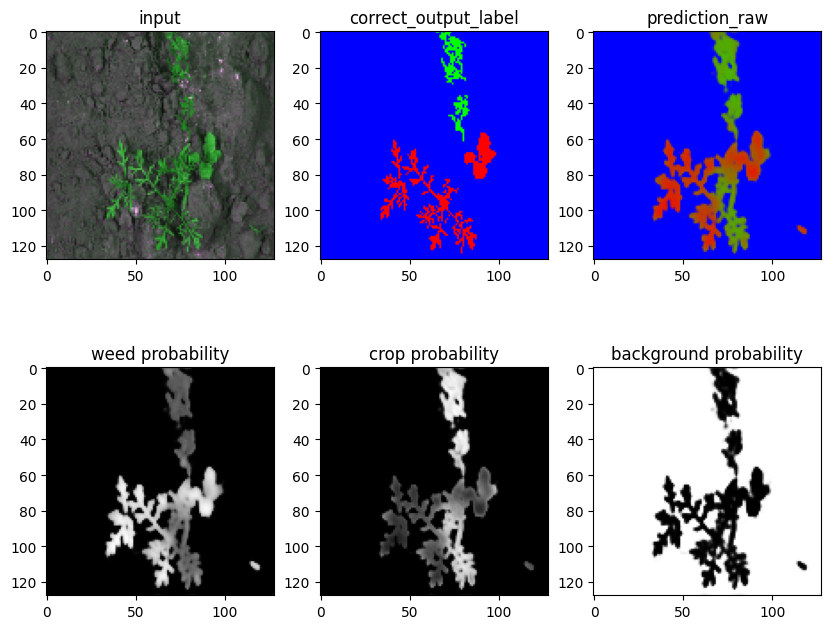

In [ ]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 3

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")

# Automodel Unet -- Auto bottom, auto parameter


## Load data

In [4]:
#read image into memory
#read image into memory
for root, dirs, files in os.walk("dataset-1.0"):
    print(root)
    print(sorted(files))

print("\n")
    
with open("dataset-1.0/train_test_split.yaml","r") as f:
    data = yaml.full_load(f)

print(data)
print("train_data is:",data["train"])
print("test_data is:",data["test"])
train_x = []
train_y = []
test_x = []
test_y = []


for number in data["train"]:

    number = "{0:03d}".format(number)

    x_path = os.path.join("dataset-1.0","images",str.format(number)) + "_image.png" 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    train_x.append(img)
    

    y_path = os.path.join("dataset-1.0","annotations",str(number)) + "_annotation.png" 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    y[:,:, 0] = weed
    y[:, :, 1] = crop
    
    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    
    train_y.append(y)
    
    
for number in data["test"]:
    number = "{0:03d}".format(number)

    x_path = os.path.join("dataset-1.0","images",str.format(number)) + "_image.png" 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    test_x.append(img)
    
    y_path = os.path.join("dataset-1.0","annotations",str(number)) + "_annotation.png" 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    
    y[:,:, 0] = weed
    y[:, :,1] = crop

    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    test_y.append(y)

    
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

#test_y = np.reshape(test_y,(-1,h,w,3))
#train_y = np.reshape(train_y,(-1,h,w,3))

#check shape
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


dataset-1.0
['README.md', 'train_test_split.yaml']
dataset-1.0/annotations
['001_annotation.png', '001_annotation.yaml', '002_annotation.png', '002_annotation.yaml', '003_annotation.png', '003_annotation.yaml', '004_annotation.png', '004_annotation.yaml', '005_annotation.png', '005_annotation.yaml', '006_annotation.png', '006_annotation.yaml', '007_annotation.png', '007_annotation.yaml', '008_annotation.png', '008_annotation.yaml', '009_annotation.png', '009_annotation.yaml', '010_annotation.png', '010_annotation.yaml', '011_annotation.png', '011_annotation.yaml', '012_annotation.png', '012_annotation.yaml', '013_annotation.png', '013_annotation.yaml', '014_annotation.png', '014_annotation.yaml', '015_annotation.png', '015_annotation.yaml', '016_annotation.png', '016_annotation.yaml', '017_annotation.png', '017_annotation.yaml', '018_annotation.png', '018_annotation.yaml', '019_annotation.png', '019_annotation.yaml', '020_annotation.png', '020_annotation.yaml', '021_annotation.png', '0

## define loss

In [5]:
#---------------------------------------------------------------------------------------------------------------------#
#generalized dice loss
def dice_coef_loss(y_true, y_pred, smooth=1e-7):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=2):
    dice=0
    for index in range(numLabels):
        #dice -= dice_coef(y_true[:,index,:,:,:], y_pred[:,index,:,:,:])
        dice -= dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
    return dice 



In [6]:
def tversky_loss_fn (y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
   #num = K.sum(p0*g0, (0,1,2,3))
    num = K.sum(p0*g0, (0,1,2))
    #den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T
#---------------------------------------------------------------------------------------------------------------------#



In [7]:

def maybe_compute_model_size(model):
    """Compute the size of a given model, if it has been built."""
    if model.built:
        params = [keras.backend.count_params(p) for p in model.trainable_weights]
        return int(np.sum(params))
    return 0


## Automodel

In [8]:

labels=3 # rgb
h=128
w=128
out_activation = "sigmoid"

def build_small_UnetFixed(hp):
    
    class MySoftmax(Layer):
        #http://cookie-box.hatenablog.com/entry/2017/08/15/231503 
        def __init__(self, **kwargs):
            super(MySoftmax, self).__init__(**kwargs)
        def call(self, x):
            return(activations.softmax(x, axis=3))

    
    
    #block1, 128x128
    inputs = layers.Input(shape=(h,w,3))
    conv11 = layers.Conv2D(16,(3,3),activation="relu",padding="same")(inputs)
    conv12= layers.Conv2D(16,(3,3),activation="relu",padding="same")(conv11)
    conv13= layers.Conv2D(16,(3,3),activation="relu",padding="same")(conv12)
    pool1 = layers.MaxPool2D((2,2))(conv13)
    drop1 = layers.Dropout(0.5)(pool1)
   #block2 64x64
    conv21 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(drop1)
    conv22 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(conv21)
    conv23 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(conv22)
    pool2 = layers.MaxPool2D((2,2))(conv23)
    drop2 = layers.Dropout(0.5)(pool2)
    #block3 32x32
    conv31 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(drop2)
    conv32 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv31)
    conv33 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv32)
    pool3 = layers.MaxPool2D((2,2))(conv33)
    drop3 = layers.Dropout(0.5)(pool3)

    #block4 16x16
    conv41 = layers.Conv2D(128,(3,3),activation="relu",padding="same")(drop3)
    conv42 = layers.Conv2D(128,(3,3),activation="relu",padding="same")(conv41)
    conv43 = layers.Conv2D(128,(3,3),activation="relu",padding="same")(conv42)
    pool4 = layers.MaxPool2D((2,2))(conv43)
    drop4 = layers.Dropout(0.5)(pool4)
    
    #bottom of Unet 8x8
    
    num_step = hp.Int("num_bottom",2,6 ,default=2)
    
    x = drop4
    for i in range(num_step):
        x = layers.Conv2D(256,(3,3),activation="relu",padding="same")(x)
    
    #conv5 = layers.Conv2D(256,(3,3),activation="relu",padding="same")(conv5)

    #upblock4
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv43,x])
    x= layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #upblock3
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv33,x])
    x= layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #upblock2
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv23,x])
    x= layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #upblock1
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv13,x])
    x= layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #to label image (2 labels)
    x = layers.Conv2D(labels,(1,1))(x)
    
    x = layers.Reshape((128*128,3))(x)
    if out_activation == "sigmoid":
        outputs = layers.Activation("sigmoid")(x)
    elif out_activation == "softmax":
        outputs =MySoftmax()(x)
    elif  out_activation == None:
        outputs = x
    model = Model(inputs=inputs,outputs=outputs)
    
    opt = hp.Choice("optimizer", ["RMSprop", "sgd"])
    loss_fn = hp.Choice("loss",[0,1,2])
    if loss_fn == 0:
         model.compile(
            optimizer=opt,
            loss="categorical_crossentropy", 
            metrics=["accuracy"]
        )
    elif loss_fn == 1: 
        model.compile(
            optimizer=opt,
            loss=dice_coef_loss, 
            metrics=["accuracy"]
        )  
    else:  
        model.compile(
            optimizer=opt,
            loss=  "categorical_crossentropy",  
            metrics=["accuracy"]
        )
    
    #model.summary()
    
   
    return model

## RandomSearch

In [26]:
#SqueezeAuto random
hp = HyperParameters()

# This will override the `learning_rate` parameter with your
# own selection of choices

hp.Choice("learning_rate", values=[ 1e-2,1e-3, 1e-4],default=1e-2)

projectname = "SmallUNetFixedRandom"
filename = projectname+'.png'

#fn_name = globals()["build_SqueezeNet_11_fixed"](hp)
 

#mymodel = Small_UnetAutoModel(labels=1)

 
tuner = RandomSearch(
    build_small_UnetFixed,
    #build_squeezenet_auto_model,
    #build_model,
    
    #hypermodel=mymodel,
    hyperparameters = hp,
    objective=Objective("val_accuracy", direction="max"),
    max_trials=200,
    executions_per_trial=1,
    overwrite=True,
    directory="mytest_dir_weed",
    project_name=projectname,
    #distribution_strategy=tf.distribute.MirroredStrategy(),
    #logger = npt_utils.NeptuneLogger(),
     
)
tuner.search_space_summary()

ratio = 1.0
EPOCH = 150
batch_size = 10
""""lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-3,
                    steps_per_epoch=np.ceil(EPOCH/batch_size),
                    epochs=3)"""
my_callbacks = [
    tf.keras.callbacks.EarlyStopping('val_accuracy', patience=10),
    #lr_finder,
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
 
#tuner.search(x_train[:int(ratio*len(x_train))], y_train[:int(ratio*len(y_train))], epochs=EPOCH, callbacks = my_callbacks,validation_data=(x_test[:int(ratio*len(x_test))], y_test[:int(ratio*len(y_test))]))

tuner.search(train_x, train_y, batch_size=batch_size, epochs=EPOCH, verbose=1,callbacks = my_callbacks,validation_data=(test_x,test_y))

models = tuner.get_best_models(num_models=10)
tuner.results_summary()
#npt_utils.log_tuner_info(tuner)


print("eval")
best_model = tuner.get_best_models(num_models=10)[0]
best_model.evaluate(test_x, test_y)

print("model size")
for i in range(len(models)):
    print("{}, {}".format(i,maybe_compute_model_size(models[i])))
    

Trial 72 Complete [00h 00m 03s]
val_accuracy: 0.0573236383497715

Best val_accuracy So Far: 0.972967267036438
Total elapsed time: 00h 04m 58s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in mytest_dir_weed/SmallUNetFixedRandom
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_bottom: 5
optimizer: RMSprop
loss: 0
Score: 0.972967267036438
Trial summary
Hyperparameters:
learning_rate: 0.001
num_bottom: 4
optimizer: RMSprop
loss: 0
Score: 0.9720807671546936
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_bottom: 6
optimizer: RMSprop
loss: 0
Score: 0.9714035987854004
Trial summary
Hyperparameters:
learning_rate: 0.01
num_bottom: 6
optimizer: sgd
loss: 2
Score: 0.9259178638458252
Trial summary
Hyperparameters:
learning_rate: 0.01
num_bottom: 2
optimizer: RMSprop
loss: 2
Score: 0.925906240940094
Trial summary
Hyperparameters:
learning_rate: 0.001
num_bottom: 5
optimizer: RMSprop
loss: 0
Score: 0.9258800745010376
Trial summary
Hyperparame

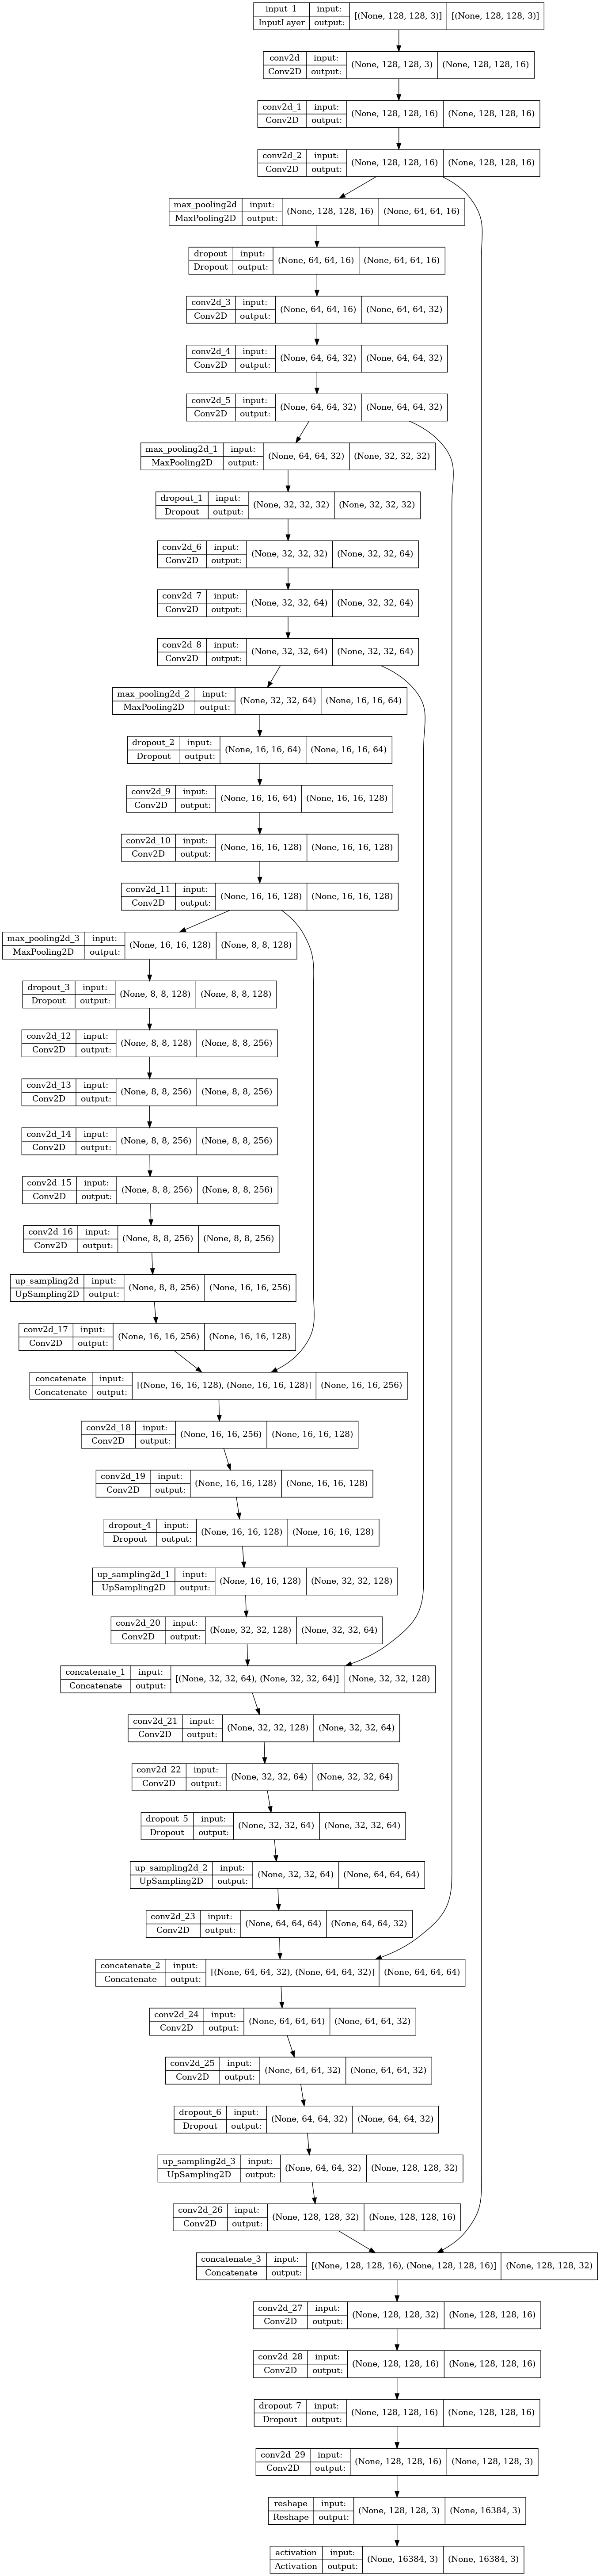

In [27]:
#alternative visualization of model structure
plot_model(best_model, to_file="best_model_rand_plot.png", show_shapes=True, show_layer_names=True)

Image("best_model_rand_plot.png")

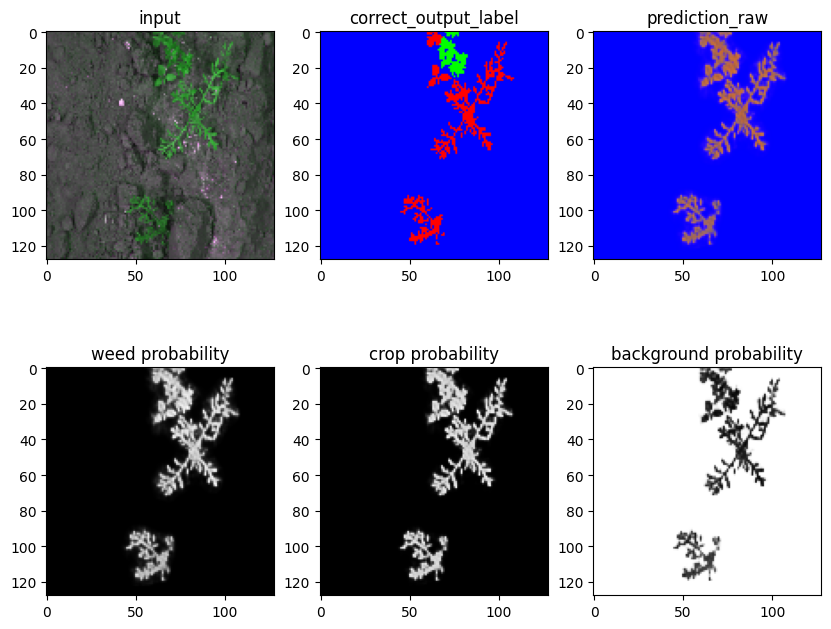

In [28]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 4
model = best_model

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")

## Bayes


In [8]:
#Bayes

hp = HyperParameters()

# This will override the `learning_rate` parameter with your
# own selection of choices

hp.Choice("learning_rate", values=[ 1e-2,1e-3, 1e-4],default=1e-2)

projectname = "SmallUNetFixedBayes"
filename = projectname+'.png'

#fn_name = globals()["build_SqueezeNet_11_fixed"](hp)
 

#mymodel = Small_UnetAutoModel(labels=1)


tuner = BayesianOptimization(
    #build_SqueezeNet_11_fixed,
    #build_squeezenet_auto_model,
    #build_model,
    
    build_small_UnetFixed,
    hyperparameters = hp,
    objective="val_accuracy",
    max_trials=200,
    executions_per_trial=1,
    overwrite=True,
    directory="mytest_dir1",
    project_name=projectname,
    #distribution_strategy=tf.distribute.MirroredStrategy(),
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    tune_new_entries=True,
    allow_new_entries=True,
   # logger = npt_utils.NeptuneLogger(),
     
)

 
tuner.search_space_summary()

ratio = 1.0
EPOCH = 150
batch_size = 10
""""lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-3,
                    steps_per_epoch=np.ceil(EPOCH/batch_size),
                    epochs=3)"""
my_callbacks = [
    tf.keras.callbacks.EarlyStopping('val_accuracy', patience=10),
    #lr_finder,
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
 
#tuner.search(x_train[:int(ratio*len(x_train))], y_train[:int(ratio*len(y_train))], epochs=EPOCH, callbacks = my_callbacks,validation_data=(x_test[:int(ratio*len(x_test))], y_test[:int(ratio*len(y_test))]))

tuner.search(train_x, train_y, batch_size=batch_size, epochs=EPOCH, verbose=1,callbacks = my_callbacks,validation_data=(test_x,test_y))

models = tuner.get_best_models(num_models=10)
tuner.results_summary()
#npt_utils.log_tuner_info(tuner)


print("eval")
best_model = tuner.get_best_models(num_models=10)[0]
best_model.evaluate(test_x, test_y)

print("model size")
for i in range(len(models)):
    print("{}, {}".format(i,maybe_compute_model_size(models[i])))

Trial 101 Complete [00h 00m 03s]
val_accuracy: 0.9258800745010376

Best val_accuracy So Far: 0.9735892415046692
Total elapsed time: 00h 11m 17s

Search: Running Trial #102

Value             |Best Value So Far |Hyperparameter
0.0001            |0.0001            |learning_rate
2                 |2                 |num_bottom
RMSprop           |RMSprop           |optimizer
2                 |2                 |loss

Epoch 1/150
4/4 [==============================] - 1s 99ms/step - loss: 0.9691 - accuracy: 0.5654 - val_loss: 120.3293 - val_accuracy: 0.9189
Epoch 2/150
4/4 [==============================] - 0s 54ms/step - loss: 114.7435 - accuracy: 0.8843 - val_loss: 0.6120 - val_accuracy: 0.9259
Epoch 3/150
4/4 [==============================] - 0s 32ms/step - loss: 0.5893 - accuracy: 0.9097 - val_loss: 0.4969 - val_accuracy: 0.9259
Epoch 4/150
4/4 [==============================] - 0s 31ms/step - loss: 0.5486 - accuracy: 0.9097 - val_loss: 0.4550 - val_accuracy: 0.9259
Epoch 5/150
4/4 [

KeyboardInterrupt: 

In [9]:
models = tuner.get_best_models(num_models=10)
tuner.results_summary()
#npt_utils.log_tuner_info(tuner)


print("eval")
best_model = tuner.get_best_models(num_models=10)[0]
best_model.evaluate(test_x, test_y)

print("model size")
for i in range(len(models)):
    print("{}, {}".format(i,maybe_compute_model_size(models[i])))

Results summary
Results in mytest_dir1/SmallUNetFixedBayes
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_bottom: 2
optimizer: RMSprop
loss: 2
Score: 0.9735892415046692
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_bottom: 2
optimizer: RMSprop
loss: 2
Score: 0.9730108380317688
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_bottom: 2
optimizer: RMSprop
loss: 2
Score: 0.9727492332458496
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_bottom: 2
optimizer: RMSprop
loss: 2
Score: 0.9717698097229004
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_bottom: 2
optimizer: RMSprop
loss: 2
Score: 0.9716535210609436
Trial summary
Hyperparameters:
learning_rate: 0.001
num_bottom: 2
optimizer: RMSprop
loss: 0
Score: 0.9711158275604248
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_bottom: 2
optimizer: RMSprop
loss: 0
Score: 0.9709792137145996
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_bottom: 2
optimizer: R

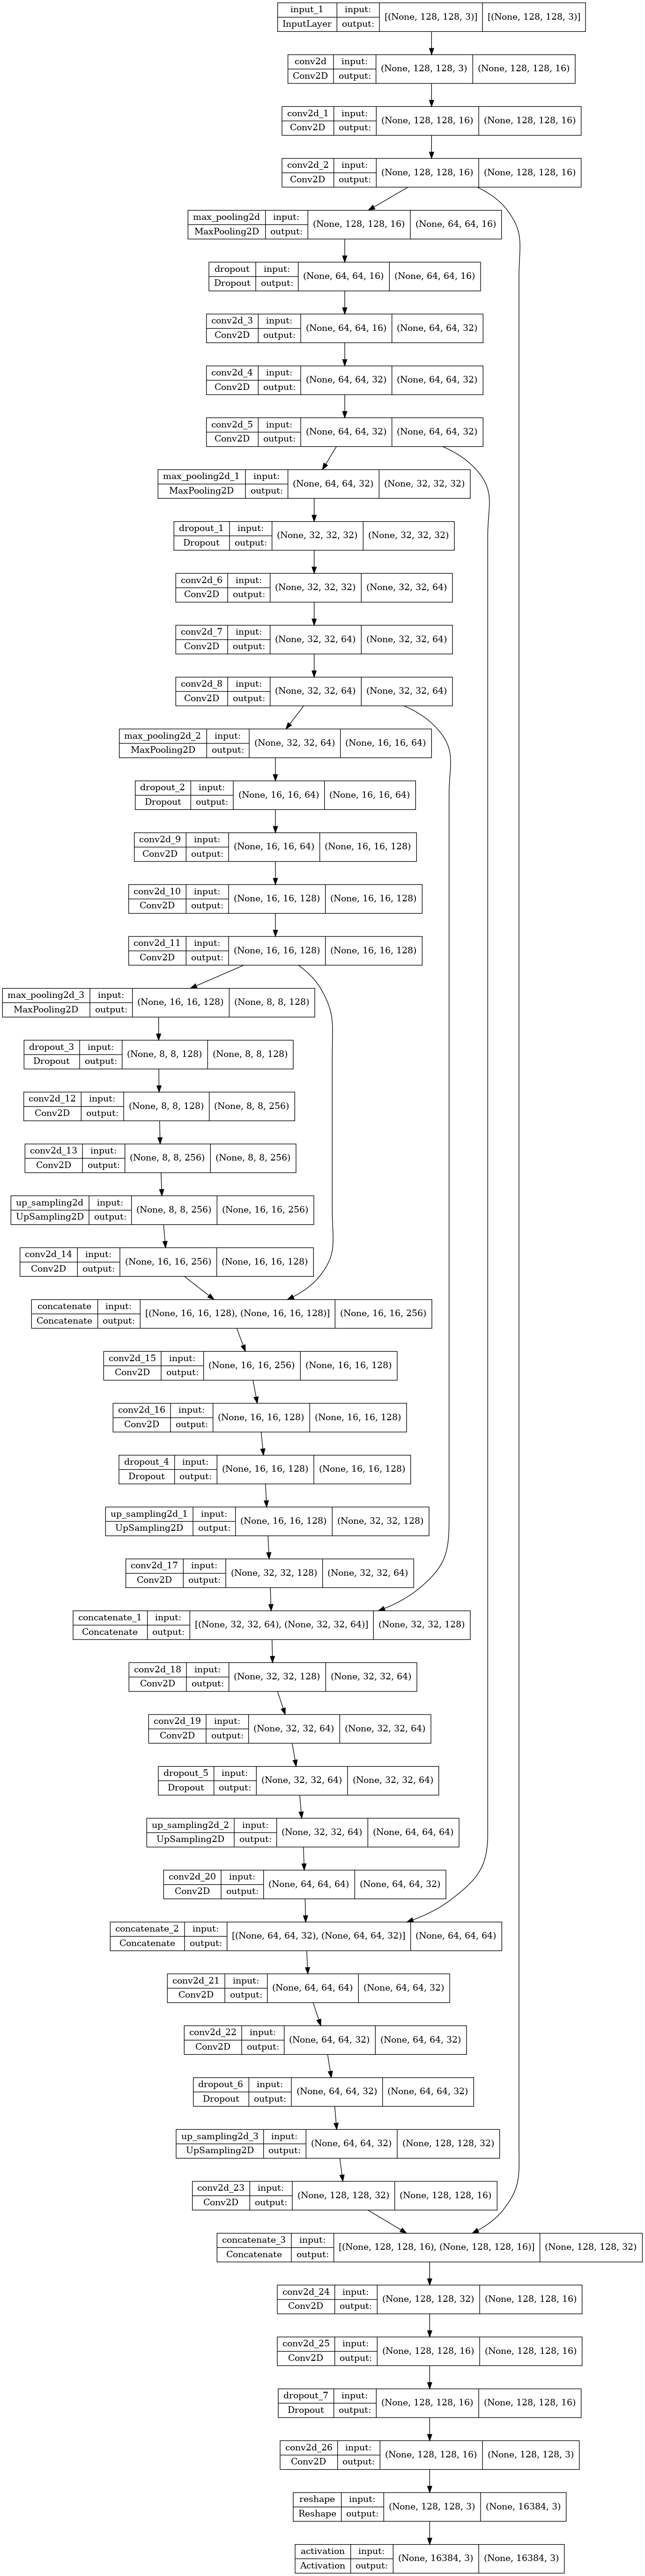

In [10]:
#alternative visualization of model structure
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

Image(filename)


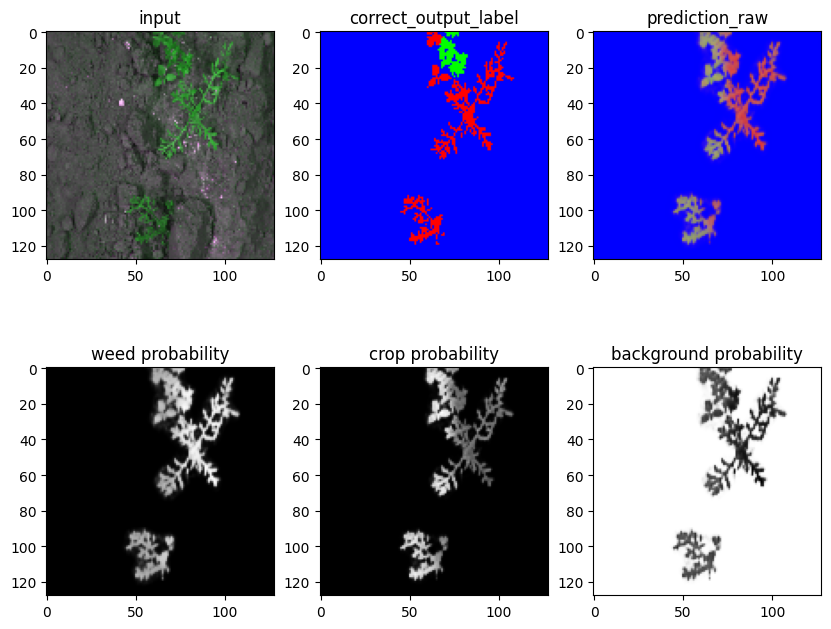

In [11]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 4
model = best_model

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")

## Hyperband

In [21]:
ratio = 1.0
EPOCH = 150
batch_size = 10

In [22]:


hp = HyperParameters()

# This will override the `learning_rate` parameter with your
# own selection of choices

hp.Choice("learning_rate", values=[ 1e-2,1e-3, 1e-4],default=1e-2)

projectname = "SmallUNetFixedHyper"
filename = projectname+'.png'

#fn_name = globals()["build_SqueezeNet_11_fixed"](hp)
 

#mymodel = Small_UnetAutoModel(labels=1)


tuner = Hyperband(
    #build_SqueezeNet_11_fixed,
    #build_squeezenet_auto_model,
    #build_model,
    build_small_UnetFixed,
     
    hyperparameters = hp,
    objective="val_accuracy",
    #max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory="mytest_dir1",
    project_name=projectname,
    #distribution_strategy=tf.distribute.MirroredStrategy(),
    max_epochs=EPOCH,
    
     
)

 
tuner.search_space_summary()

ratio = 1.0
EPOCH = 150
batch_size = 10
""""lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-3,
                    steps_per_epoch=np.ceil(EPOCH/batch_size),
                    epochs=3)"""
my_callbacks = [
    tf.keras.callbacks.EarlyStopping('val_accuracy', patience=10),
    #lr_finder,
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
 
#tuner.search(x_train[:int(ratio*len(x_train))], y_train[:int(ratio*len(y_train))], epochs=EPOCH, callbacks = my_callbacks,validation_data=(x_test[:int(ratio*len(x_test))], y_test[:int(ratio*len(y_test))]))

tuner.search(train_x, train_y, batch_size=batch_size, epochs=EPOCH, verbose=1,callbacks = my_callbacks,validation_data=(test_x,test_y))

models = tuner.get_best_models(num_models=10)
tuner.results_summary()
#npt_utils.log_tuner_info(tuner)


print("eval")
best_model = tuner.get_best_models(num_models=10)[0]
best_model.evaluate(test_x, test_y)

print("model size")
for i in range(len(models)):
    print("{}, {}".format(i,maybe_compute_model_size(models[i])))

Trial 86 Complete [00h 00m 02s]
val_accuracy: 0.9258800745010376

Best val_accuracy So Far: 0.9326695203781128
Total elapsed time: 00h 02m 16s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in mytest_dir1/SmallUNetFixedHyper
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.001
num_bottom: 5
optimizer: sgd
loss: 2
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.9326695203781128
Trial summary
Hyperparameters:
learning_rate: 0.001
num_bottom: 3
optimizer: RMSprop
loss: 0
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.9258800745010376
Trial summary
Hyperparameters:
learning_rate: 0.001
num_bottom: 5
optimizer: RMSprop
loss: 2
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.9258800745010376
Trial summary
Hyperparameters:
learning_rate: 0.001
num_bottom: 6
optimizer: RMSprop
loss: 0
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 

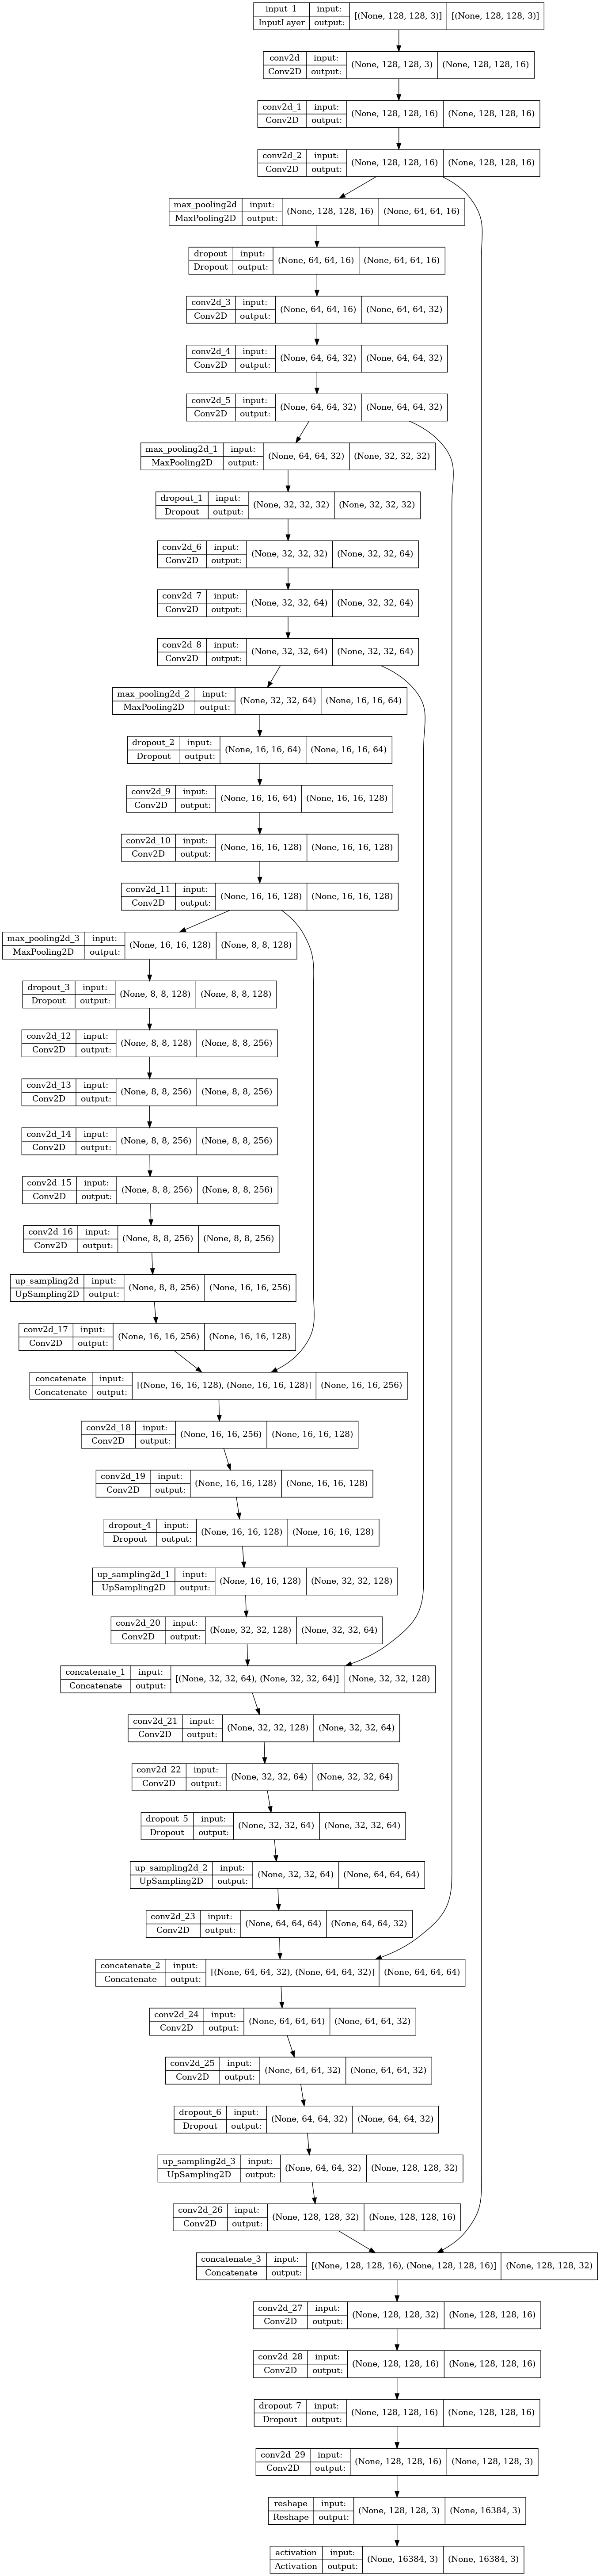

In [23]:
#alternative visualization of model structure
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

Image(filename)


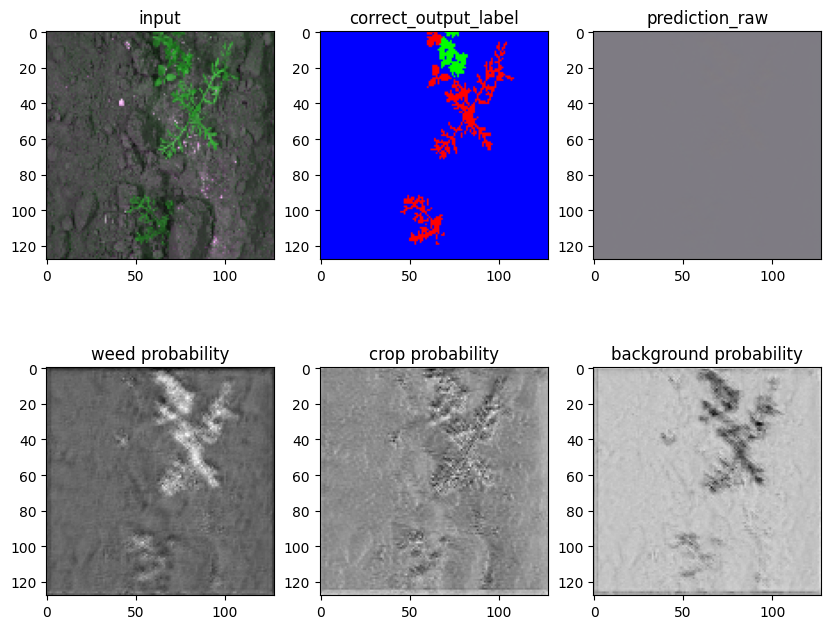

In [24]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 4
model = best_model

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")

# Automodel Unet -- Auto layers, auto parameters

## Automodel

In [9]:
h = 128
w =128
def create_downblock(conv_d,x):
        
        num_block = hp.Int("num_conv_block_dwon", 1,5 , default=3)
        
        for i in range(num_block):
            
            x = layers.Conv2D(conv_d,(3,3),activation="relu",padding="same")(x)
       
        concat_input = x
        
        x = layers.MaxPool2D((2,2))(x)
        
        dropout_rate = hp.Choice('dropout_rate',values=[0.1,0.5,0.8])
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)
            
        return x, concat_input
    
def create_upblock(conv_d,x,y):
        
    num_block = hp.Int("num_conv_block_up", 1,3, default=1)

    x = layers.UpSampling2D((2,2))(x)
    for i in range(num_block):
        x = layers.Conv2D(conv_d,(3,3),activation="relu",padding="same")(x)

    x = layers.concatenate([y,x])
    num_block2 = hp.Int("num_conv_block_up2", 1,5 ,default=2)

    for i in range(num_block2): 
        x= layers.Conv2D(conv_d,(3,3),activation="relu",padding="same")(x)

    dropout_rate = hp.Choice('dropout_rate',values=[0.1,0.5,0.8])
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    return x   
class MySoftmax(Layer):
        #http://cookie-box.hatenablog.com/entry/2017/08/15/231503 
        def __init__(self, **kwargs):
            super(MySoftmax, self).__init__(**kwargs)
        def call(self, x):
            return(activations.softmax(x, axis=3))

        
def build_small_UnetAuto(hp):

    #block1, 128x128
    inputs = layers.Input(shape=(h,w,3))
    
    conv_d = hp.Choice("num_conv", values=[ 8,16,32], default=16)
        
    num_step = hp.Int("numstep", 3,6 ,default=4)

    concat_inputs = []
    
    
    i = conv_d
    x = inputs
    j = 0

    while j < num_step:
        x,c_in = create_downblock(i,x)
        concat_inputs.insert(0,c_in)
         
        i = i *2
        j = j+1
     
   
    
    #bottom of Unet 8x8
    
    num_step_b = hp.Int("num_bottom",2,6 ,default=2)
    
    
    for i in range(num_step_b):
        x = layers.Conv2D(256,(3,3),activation="relu",padding="same")(x)
    
    #conv5 = layers.Conv2D(256,(3,3),activation="relu",padding="same")(conv5)

        
    i  =256
    i = i //2
    j = 0
    while j < num_step:
        x = create_upblock(i,x,concat_inputs[j])
        i = i//2
        j = j+1
            
         

    
    #to label image (2 labels)
    x = layers.Conv2D(labels,(1,1))(x)
    
    x = layers.Reshape((128*128,3))(x)
    if out_activation == "sigmoid":
        outputs = layers.Activation("sigmoid")(x)
    elif out_activation == "softmax":
        outputs =MySoftmax()(x)
    elif  out_activation == None:
        outputs = x
    model = Model(inputs=inputs,outputs=outputs)
    
    opt = hp.Choice("optimizer", ["RMSprop", "sgd"])
    loss_fn = hp.Choice("loss",[0,1,2])
    if loss_fn == 0:
         model.compile(
            optimizer=opt,
            loss="categorical_crossentropy", 
            metrics=["accuracy"]
        )
    elif loss_fn == 1: 
        model.compile(
            optimizer=opt,
            loss=dice_coef_loss, 
            metrics=["accuracy"]
        )  
    else:  
        model.compile(
            optimizer=opt,
            loss=  "categorical_crossentropy",  
            metrics=["accuracy"]
        )
    
    #model.summary()
    
   
    return model

## Random Search

In [26]:

#SqueezeAuto random
hp = HyperParameters()
# This will override the `learning_rate` parameter with your
# own selection of choices

projectname = "SmallUNetAutoRandom"
filename = projectname+'.png'

hp.Choice("learning_rate", values=[ 1e-2,1e-3, 1e-4],default=1e-2)



#fn_name = globals()["build_SqueezeNet_11_fixed"](hp)
 
 
 
tuner = RandomSearch(
     
    build_small_UnetAuto,
    #build_model,
    
    #hypermodel=mymodel,
    hyperparameters = hp,
    objective=Objective("val_accuracy", direction="max"),
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory="mytest_dir_unet_auto_weed",
    project_name=projectname,
    #distribution_strategy=tf.distribute.MirroredStrategy(),
    #logger = npt_utils.NeptuneLogger(),
     
)
tuner.search_space_summary()


EPOCH = 150
batch_size = 10
""""lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-3,
                    steps_per_epoch=np.ceil(EPOCH/batch_size),
                    epochs=3)"""
my_callbacks = [
    tf.keras.callbacks.EarlyStopping('val_accuracy', patience=10),
    #lr_finder,
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
 
#tuner.search(x_train[:int(ratio*len(x_train))], y_train[:int(ratio*len(y_train))], epochs=EPOCH, callbacks = my_callbacks,validation_data=(x_test[:int(ratio*len(x_test))], y_test[:int(ratio*len(y_test))]))

tuner.search(train_x, train_y, batch_size=batch_size, epochs=EPOCH, verbose=1,callbacks = my_callbacks,validation_data=(test_x,test_y))

models = tuner.get_best_models(num_models=10)
tuner.results_summary()
#npt_utils.log_tuner_info(tuner)


print("eval")
best_model = tuner.get_best_models(num_models=10)[0]
best_model.evaluate(test_x, test_y)


print("model size")
for i in range(len(models)):
    print("{}, {}".format(i,maybe_compute_model_size(models[i])))

Trial 100 Complete [00h 00m 03s]
val_accuracy: 0.0573236383497715

Best val_accuracy So Far: 0.9779924750328064
Total elapsed time: 00h 12m 02s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in mytest_dir_unet_auto_weed/SmallUNetAutoRandom
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_conv_block_dwon: 4
dropout_rate: 0.8
num_conv_block_up: 1
num_conv_block_up2: 1
num_conv: 32
numstep: 4
num_bottom: 5
optimizer: RMSprop
loss: 0
Score: 0.9779924750328064
Trial summary
Hyperparameters:
learning_rate: 0.001
num_conv_block_dwon: 4
dropout_rate: 0.5
num_conv_block_up: 2
num_conv_block_up2: 5
num_conv: 32
numstep: 3
num_bottom: 3
optimizer: RMSprop
loss: 0
Score: 0.9753650426864624
Trial summary
Hyperparameters:
learning_rate: 0.01
num_conv_block_dwon: 4
dropout_rate: 0.5
num_conv_block_up: 1
num_conv_block_up2: 2
num_conv: 16
numstep: 5
num_bottom: 5
optimizer: RMSprop
loss: 0
Score: 0.9712321162223816
Trial summary
Hyperparameters:
learning_r

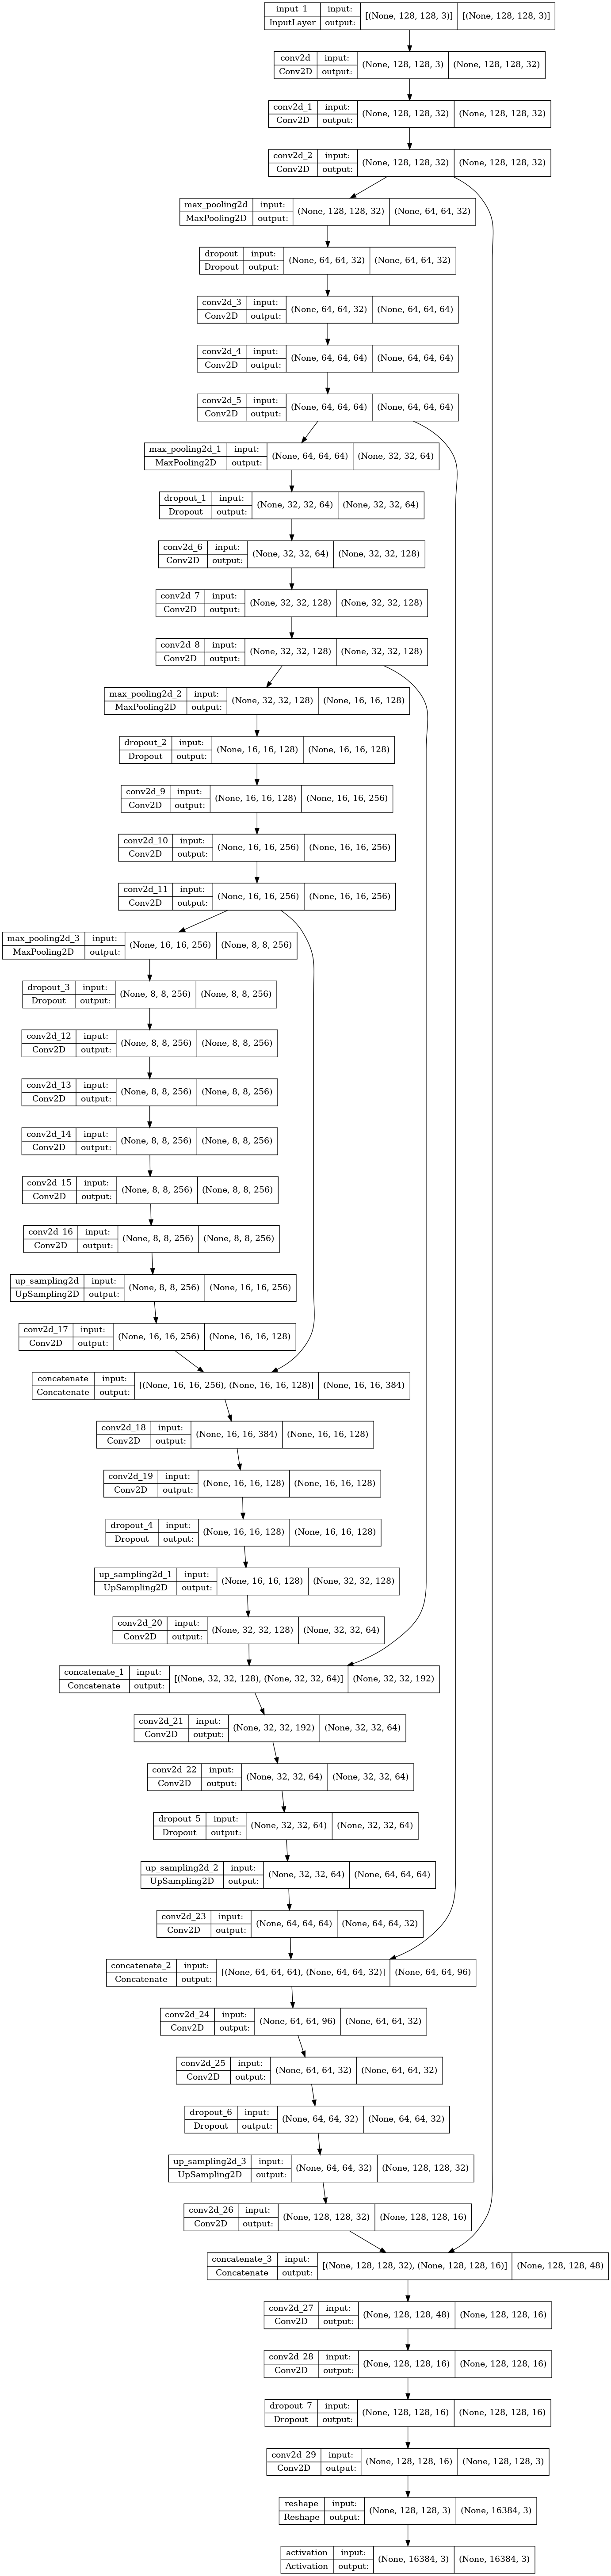

In [27]:
#alternative visualization of model structure
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

Image(filename)



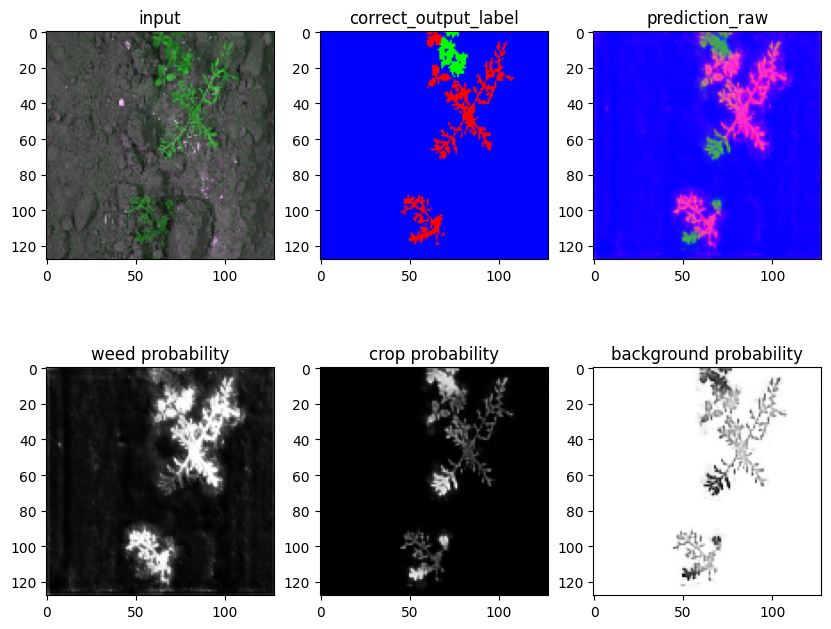

In [28]:

# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 4
model = best_model

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")


## Bayes

In [10]:
#Bayes

hp = HyperParameters()

# This will override the `learning_rate` parameter with your
# own selection of choices

hp.Choice("learning_rate", values=[ 1e-2,1e-3, 1e-4],default=1e-2)

projectname = "SmallUNetAutoBayes"
filename = projectname+'.png'

#fn_name = globals()["build_SqueezeNet_11_fixed"](hp)
 

#mymodel = Small_UnetAutoModel(labels=1)


tuner = BayesianOptimization(
    #build_SqueezeNet_11_fixed,
    #build_squeezenet_auto_model,
    #build_model,
    
   build_small_UnetAuto,
    hyperparameters = hp,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory="mytest_dir1",
    project_name=projectname,
    #distribution_strategy=tf.distribute.MirroredStrategy(),
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    tune_new_entries=True,
    allow_new_entries=True,
   # logger = npt_utils.NeptuneLogger(),
     
)

 
tuner.search_space_summary()

ratio = 1.0
EPOCH = 150
batch_size = 10
""""lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-3,
                    steps_per_epoch=np.ceil(EPOCH/batch_size),
                    epochs=3)"""
my_callbacks = [
    tf.keras.callbacks.EarlyStopping('val_accuracy', patience=10),
    #lr_finder,
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
 
#tuner.search(x_train[:int(ratio*len(x_train))], y_train[:int(ratio*len(y_train))], epochs=EPOCH, callbacks = my_callbacks,validation_data=(x_test[:int(ratio*len(x_test))], y_test[:int(ratio*len(y_test))]))

tuner.search(train_x, train_y, batch_size=batch_size, epochs=EPOCH, verbose=1,callbacks = my_callbacks,validation_data=(test_x,test_y))

models = tuner.get_best_models(num_models=10)
tuner.results_summary()
#npt_utils.log_tuner_info(tuner)


print("eval")
best_model = tuner.get_best_models(num_models=10)[0]
best_model.evaluate(test_x, test_y)
print("model size")
for i in range(len(models)):
    print("{}, {}".format(i,maybe_compute_model_size(models[i])))

Trial 100 Complete [00h 00m 03s]
val_accuracy: 0.9258800745010376

Best val_accuracy So Far: 0.9749842882156372
Total elapsed time: 00h 20m 08s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in mytest_dir1/SmallUNetAutoBayes
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.01
num_conv_block_dwon: 5
dropout_rate: 0.8
num_conv_block_up: 1
num_conv_block_up2: 1
num_conv: 8
numstep: 3
num_bottom: 6
optimizer: RMSprop
loss: 2
Score: 0.9749842882156372
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_conv_block_dwon: 5
dropout_rate: 0.8
num_conv_block_up: 1
num_conv_block_up2: 2
num_conv: 32
numstep: 6
num_bottom: 6
optimizer: RMSprop
loss: 2
Score: 0.972897469997406
Trial summary
Hyperparameters:
learning_rate: 0.0001
num_conv_block_dwon: 5
dropout_rate: 0.8
num_conv_block_up: 1
num_conv_block_up2: 5
num_conv: 32
numstep: 6
num_bottom: 6
optimizer: RMSprop
loss: 2
Score: 0.9726707935333252
Trial summary
Hyperparameters:
learning_rate: 0.01
num_co

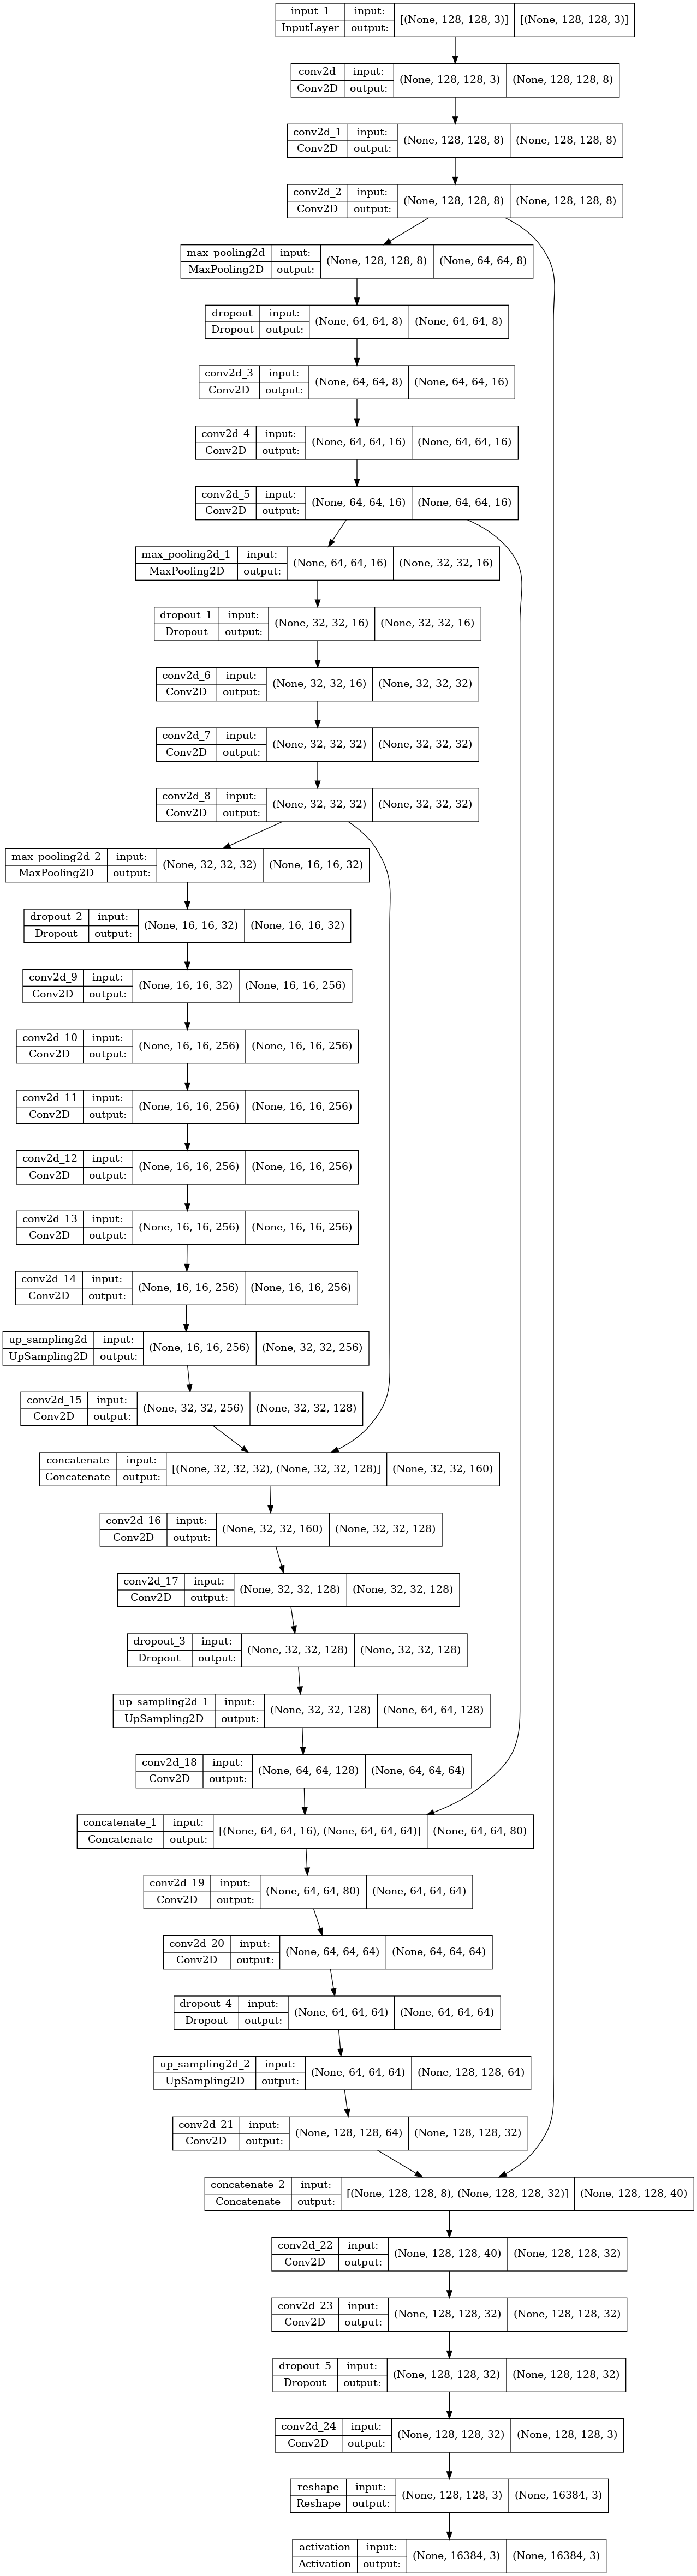

In [11]:
#alternative visualization of model structure
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

Image(filename)



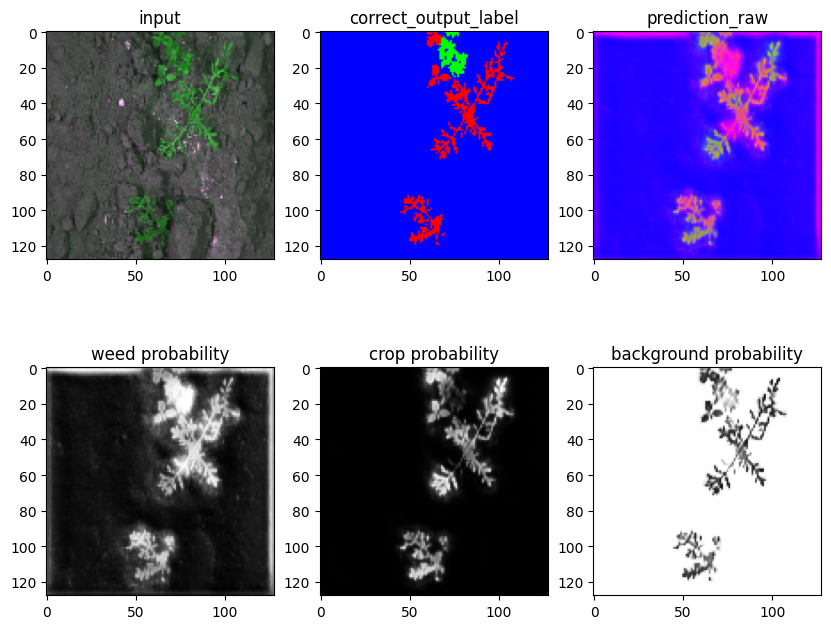

In [12]:

# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 4
model = best_model

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")


## Hyperband

In [13]:


hp = HyperParameters()

# This will override the `learning_rate` parameter with your
# own selection of choices

hp.Choice("learning_rate", values=[ 1e-2,1e-3, 1e-4],default=1e-2)

projectname = "SmallUNetAutoHyper"
filename = projectname+'.png'

#fn_name = globals()["build_SqueezeNet_11_fixed"](hp)
 

#mymodel = Small_UnetAutoModel(labels=1)


tuner = Hyperband(
    #build_SqueezeNet_11_fixed,
    #build_squeezenet_auto_model,
    #build_model,
    build_small_UnetAuto,
     
    hyperparameters = hp,
    objective="val_accuracy",
    #max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory="mytest_dir1",
    project_name=projectname,
    #distribution_strategy=tf.distribute.MirroredStrategy(),
    max_epochs=EPOCH,
    
     
)

 
tuner.search_space_summary()

ratio = 1.0
EPOCH = 150
batch_size = 10
""""lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-3,
                    steps_per_epoch=np.ceil(EPOCH/batch_size),
                    epochs=3)"""
my_callbacks = [
    tf.keras.callbacks.EarlyStopping('val_accuracy', patience=10),
    #lr_finder,
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
 
#tuner.search(x_train[:int(ratio*len(x_train))], y_train[:int(ratio*len(y_train))], epochs=EPOCH, callbacks = my_callbacks,validation_data=(x_test[:int(ratio*len(x_test))], y_test[:int(ratio*len(y_test))]))

tuner.search(train_x, train_y, batch_size=batch_size, epochs=EPOCH, verbose=1,callbacks = my_callbacks,validation_data=(test_x,test_y))

models = tuner.get_best_models(num_models=10)
tuner.results_summary()
#npt_utils.log_tuner_info(tuner)


print("eval")
best_model = tuner.get_best_models(num_models=10)[0]
best_model.evaluate(test_x, test_y)
print("model size")
for i in range(len(models)):
    print("{}, {}".format(i,maybe_compute_model_size(models[i])))

Trial 254 Complete [00h 00m 03s]
val_accuracy: 0.9258800745010376

Best val_accuracy So Far: 0.9739001989364624
Total elapsed time: 00h 11m 31s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in mytest_dir1/SmallUNetAutoHyper
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.01
num_conv_block_dwon: 5
dropout_rate: 0.8
num_conv_block_up: 1
num_conv_block_up2: 3
num_conv: 32
numstep: 3
num_bottom: 2
optimizer: RMSprop
loss: 0
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 0.9739001989364624
Trial summary
Hyperparameters:
learning_rate: 0.001
num_conv_block_dwon: 2
dropout_rate: 0.5
num_conv_block_up: 3
num_conv_block_up2: 3
num_conv: 16
numstep: 3
num_bottom: 5
optimizer: RMSprop
loss: 0
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.9738304615020752
Trial summary
Hyperparameters:
learning_rate: 0.001
num_conv_block_dwon: 2
dropout_rate: 0.5
n

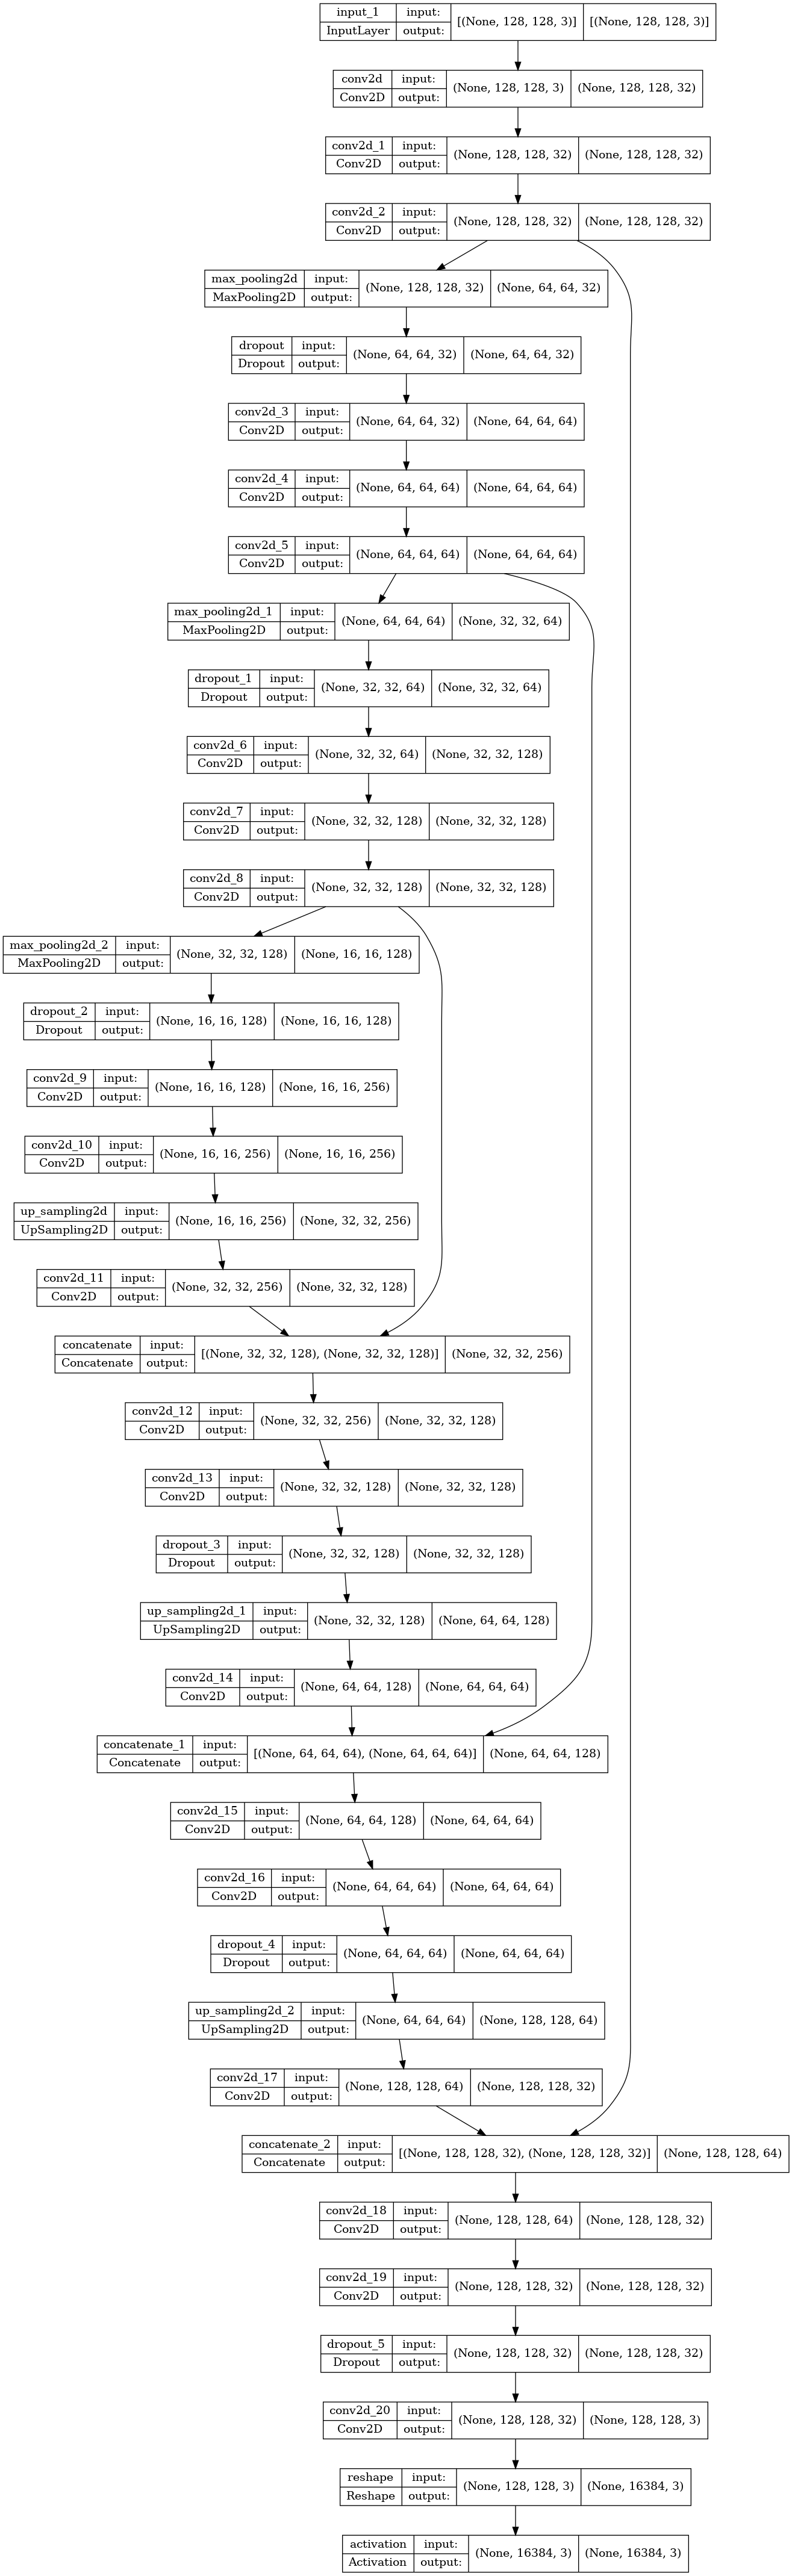

In [14]:
#alternative visualization of model structure
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

Image(filename)


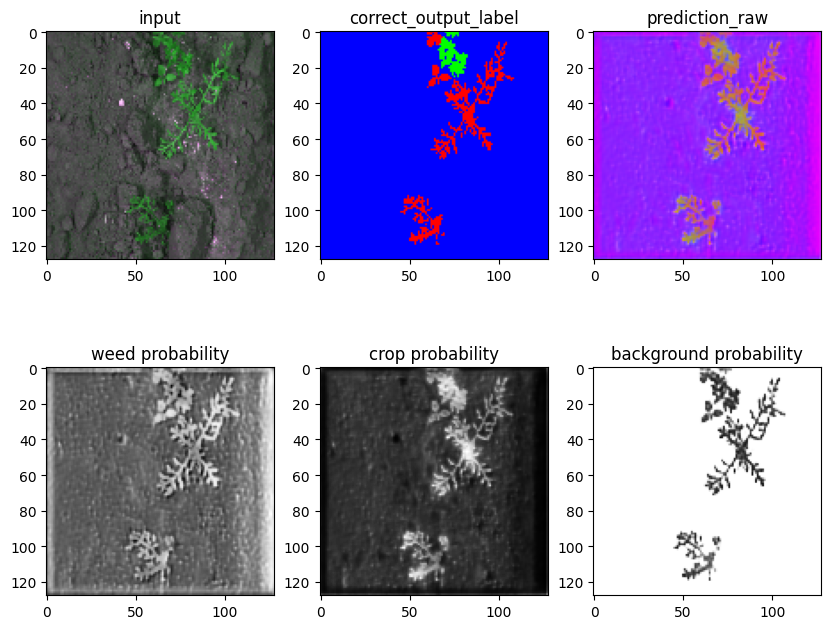

In [15]:

# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 4
model = best_model

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")
